In [1]:
# import all modules required for the analyses
import os
import pandas as pd
import numpy as np
from scipy.stats import boxcox
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.formula.api import ols
from statsmodels.formula.api import glm
from statsmodels.stats.api import anova_lm
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
%matplotlib inline

In [2]:
# change working directory
os.getcwd()

'C:\\Users\\Administrator\\Documents\\Advanced data\\final'

In [3]:
# change current working directory
os.chdir('../data')

In [4]:
# read the credit data
raw_df = pd.read_csv("Flourishing_N317_v2.csv", index_col=0)

# PART 1 Data Cleaning & Prep

In [6]:
df = pd.DataFrame(raw_df)

# Step 1: Identify columns to apply the replacement
columns_to_modify = df.columns.difference(['SEX'])

# Replace 0 and 7 with NaN in the specified columns
df[columns_to_modify] = df[columns_to_modify].replace([0, 7], np.nan)

# Step 2: Drop columns with more than 50% missing values
threshold_col = len(df) * 0.5
df = df.dropna(axis=1, thresh=threshold_col)

# Step 3: Drop rows with more than 50% missing values
threshold_row = len(df.columns) * 0.5
df = df.dropna(axis=0, thresh=threshold_row)

In [7]:
#Step 4: Impute missing values for numerical columns using median
numerical_cols = df.select_dtypes(include=[np.number]).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

#Step 5: Impute missing values for categorical columns using mode
categorical_cols = df.select_dtypes(exclude=[np.number]).columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print(df)

                    GUI               SECTEUR  TAILLE FONCTION  ANCIENNETE  \
Individu                                                                     
83        c7251f433fbaa                           2.0                  5.0   
151       c72c265502d92                           2.0                  5.0   
177        c7356f5742de                           2.0                  5.0   
184       c735b612f44b9                           2.0                  5.0   
198       c7370624543b7                           2.0                  5.0   
...                 ...                   ...     ...      ...         ...   
411       c788295045c64  Pratiques somatiques     1.0                  4.0   
421       c791ff32a2577                 sante     1.0                  9.0   
100        c72625524121                           2.0                  1.0   
294       c768cf13e0ce7                           2.0                  1.0   
395       c7838d57eab6c                           1.0           

In [8]:
# Step 6: Computing new categorical variables

# Define MHCB (Professional context) and MHCC (Private context) items
MHCB_columns = [col for col in df.columns if 'MHCB' in col]  
MHCC_columns = [col for col in df.columns if 'MHCC' in col]  

# Function to compute flourishing status for a specific context
def compute_contextual_flourishing_status(row, context_columns):
    # Emotional Well-Being (EWB) subset for the context
    ewb_columns = context_columns[:3]
    swb_pwb_columns = context_columns[3:]
    
    # Compute Flourishing and Languishing conditions
    flourishing_ewb = row[ewb_columns].isin([5, 6]).any()
    languishing_ewb = row[ewb_columns].isin([1, 2]).any()
    
    flourishing_swb_pwb = row[swb_pwb_columns].isin([5, 6]).sum() >= 6
    languishing_swb_pwb = row[swb_pwb_columns].isin([1, 2]).sum() >= 6

    # Assign Flourishing status
    if flourishing_ewb and flourishing_swb_pwb:
        return "Flourishing"
    elif languishing_ewb and languishing_swb_pwb:
        return "Languishing"
    else:
        return "Moderate"

# Compute flourishing status for Professional (MHCB) and Private (MHCC) contexts
df['Professional_Flourishing_Status'] = df.apply(
    compute_contextual_flourishing_status, axis=1, context_columns=MHCB_columns)
df['Private_Flourishing_Status'] = df.apply(
    compute_contextual_flourishing_status, axis=1, context_columns=MHCC_columns)

# Define positive (PE) and negative (NE) emotion columns based on their names
positive_emotion_columns = [col for col in df.columns if 'PE' in col]
negative_emotion_columns = [col for col in df.columns if 'NE' in col]

# Ensure these columns exist in the dataset
positive_emotion_columns = [col for col in positive_emotion_columns if col in df.columns]
negative_emotion_columns = [col for col in negative_emotion_columns if col in df.columns]

# Calculate positivity ratio (PsurN)
df['PsurN'] = df[positive_emotion_columns].sum(axis=1) / df[negative_emotion_columns].sum(axis=1)

#  Define emotional flourishing status based on PsurN
def emotional_flourishing_status(psur_n):
    if psur_n > 3:
        return "Emotionally Flourishing"
    elif 2 < psur_n <= 3:
        return "Moderately Emotionally Healthy"
    elif 1 < psur_n <= 2:
        return "Emotionally Languishing"
    else:
        return "Depressed"

df['Emotional_Flourishing_Status'] = df['PsurN'].apply(emotional_flourishing_status)

display(df)

GUI               SECTEUR  TAILLE FONCTION  ANCIENNETE  \
Individu                                                                     
83        c7251f433fbaa                           2.0                  5.0   
151       c72c265502d92                           2.0                  5.0   
177        c7356f5742de                           2.0                  5.0   
184       c735b612f44b9                           2.0                  5.0   
198       c7370624543b7                           2.0                  5.0   
...                 ...                   ...     ...      ...         ...   
411       c788295045c64  Pratiques somatiques     1.0                  4.0   
421       c791ff32a2577                 sante     1.0                  9.0   
100        c72625524121                           2.0                  1.0   
294       c768cf13e0ce7                           2.0                  1.0   
395       c7838d57eab6c                           1.0                 21.0   

           AGE  SEX  SITUFAM  NIVEAUETUDE                FORMATION  ...  \
Individu                                                            ...   
83        40.0    0      3.0          5.0                           ...   
151       40.0    0      3.0          5.0                           ...   
177       40.0    0      3.0          5.0                           ...   
184       40.0    0      3.0          5.0                           ...   
198       40.0    0      3.0          5.0                           ...   
...        ...  ...      ...          ...                      ...  ...   
411       33.0    0      1.0          3.0  Scientifique/artistique  ...   
421       45.0    0      3.0          6.0                  medecin  ...   
100       40.0    1      3.0          3.0                           ...   
294       40.0    0      3.0          3.0                           ...   
395       64.0    1      3.0          1.0                           ...   

          Flux4  Flux5  Flux6  Flux7  Flux8  Flux9  \
Individu                                             
83          5.0    4.0    4.0    4.0    5.0    4.0   
151         5.0    4.0    4.0    4.0    5.0    4.0   
177         5.0    4.0    4.0    4.0    5.0    4.0   
184         5.0    4.0    4.0    4.0    5.0    4.0   
198         5.0    4.0    4.0    4.0    5.0    4.0   
...         ...    ...    ...    ...    ...    ...   
411         6.0    6.0    6.0    5.0    6.0    5.0   
421         5.0    5.0    4.0    4.0    4.0    3.0   
100         6.0    6.0    3.0    4.0    3.0    5.0   
294         6.0    6.0    4.0    6.0    6.0    6.0   
395         6.0    6.0    4.0    5.0    6.0    6.0   

          Professional_Flourishing_Status  Private_Flourishing_Status  \
Individu                                                                
83                            Flourishing                 Flourishing   
151                              Moderate                    Moderate   
177                              Moderate                    Moderate   
184                              Moderate                    Moderate   
198                              Moderate                    Moderate   
...                                   ...                         ...   
411                              Moderate                    Moderate   
421                              Moderate                    Moderate   
100                              Moderate                    Moderate   
294                              Moderate                    Moderate   
395                              Moderate                    Moderate   

             PsurN  Emotional_Flourishing_Status  
Individu                                          
83        1.000000                     Depressed  
151       1.071429       Emotionally Languishing  
177       1.066667       Emotionally Languishing  
184       0.750000                     Depressed  
198       0.866667                     Depressed  
...            ... 

### Sub dataset

In [10]:
# force
force_columns =[col for col in df.columns if 'Force' in col] 
# Create a new DataFrame with only the force-related columns
force_df = df[force_columns]

# fcq
fq_columns =[col for col in df.columns if 'FQ' in col] 
# Create a new DataFrame with only the fq related columns
fq_df = df[fq_columns]

#flux
flux_columns =[col for col in df.columns if 'Flux' in col] 
# Create a new DataFrame with only the flux related columns
flux_df = df[flux_columns]

# PART 2 PCA

In [12]:
# import the usual modules
# to manage directories
import os
# to handle matrix computations
import numpy as np
# to handle tabular data
import pandas as pd
# to handle plots and graphs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [13]:
# if fanalysis is already installed, import it - else install and import it
try:
    from fanalysis.pca import PCA
except:
    !pip install fanalysis
    from fanalysis.pca import PCA

## Force_df

In [15]:
# print dataset summary
print(force_df.info())

# define dimensions of [X] matrix : number of variables
p = force_df.shape[1]

# define sample size of [X] : number of observations
n = force_df.shape[0]

# define values of matrix [X]
X = force_df.values

<class 'pandas.core.frame.DataFrame'>
Index: 278 entries, 83 to 395
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Force1   278 non-null    float64
 1   Force4   278 non-null    float64
 2   Force6   278 non-null    float64
 3   Force8   278 non-null    float64
 4   Force12  278 non-null    float64
 5   Force13  278 non-null    float64
 6   Force17  278 non-null    float64
 7   Force18  278 non-null    float64
 8   Force19  278 non-null    float64
 9   Force22  278 non-null    float64
 10  Force23  278 non-null    float64
 11  Force24  278 non-null    float64
dtypes: float64(12)
memory usage: 28.2 KB
None


In [16]:
# import PCA module from fanalysis package
from fanalysis.pca import PCA

# instantiate acp object form PCA class
acp = PCA(std_unit=True,row_labels=force_df.index,col_labels=force_df.columns)

# run PCA on X observed data
acp.fit(X)

# print methods and attributes of acp object
print(dir(acp))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_clone__', '__sklearn_tags__', '__str__', '__subclasshook__', '__weakref__', '_build_request_for_signature', '_check_feature_names', '_check_n_features', '_compute_stats', '_compute_svd', '_doc_link_module', '_doc_link_template', '_doc_link_url_param_generator', '_get_default_requests', '_get_doc_link', '_get_metadata_request', '_get_param_names', '_get_tags', '_more_tags', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_sklearn_auto_wrap_output_keys', '_validate_data', '_validate_params', 'col_contrib_', 'col_coord_', 'col_cor_', 'col_cos2_', 'col_labels', 'col_labels_', 'col_labels_short_', 'col_topandas', 'correlation_circle', 'eig_', 'ei

In [17]:
acp.col_labels

Index(['Force1', 'Force4', 'Force6', 'Force8', 'Force12', 'Force13', 'Force17',
       'Force18', 'Force19', 'Force22', 'Force23', 'Force24'],
      dtype='object')

In [18]:
acp.row_labels

Index([ 83, 151, 177, 184, 198, 206, 226, 230, 246, 258,
       ...
       341, 467, 342,  84, 334, 411, 421, 100, 294, 395],
      dtype='int64', name='Individu', length=278)

### Determine the number of factors

In [20]:
# print eigenvalues (the lambdas) - output includes proportion of variance explained and cumulated values thereof
print(acp.eig_)

[[  4.02241889   1.20793037   0.96739934   0.90539333   0.83760274
    0.81159491   0.71248409   0.5817817    0.56483124   0.53712262
    0.4457277    0.40571307]
 [ 33.52015738  10.06608645   8.06166118   7.54494446   6.98002282
    6.76329093   5.9373674    4.84818081   4.70692697   4.47602181
    3.71439751   3.38094228]
 [ 33.52015738  43.58624383  51.64790501  59.19284947  66.17287229
   72.93616322  78.87353062  83.72171142  88.42863839  92.90466021
   96.61905772 100.        ]]


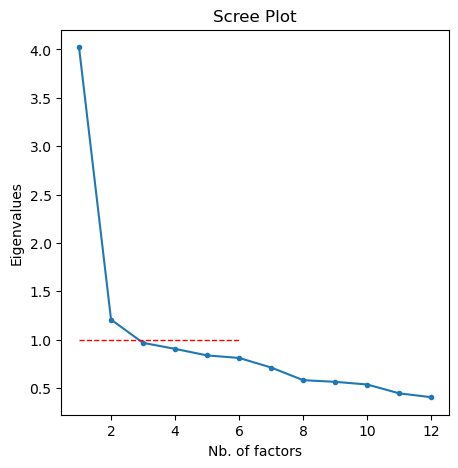

In [21]:
# print scree plot

# first the main plot
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(range(1,p+1),acp.eig_[0],".-")
ax.set_xlabel("Nb. of factors")
ax.set_ylabel("Eigenvalues")
plt.title("Scree Plot")

# add Kaiser's threshold line
ax.plot([1,6],[1,1],"r--",linewidth=1)

plt.show()

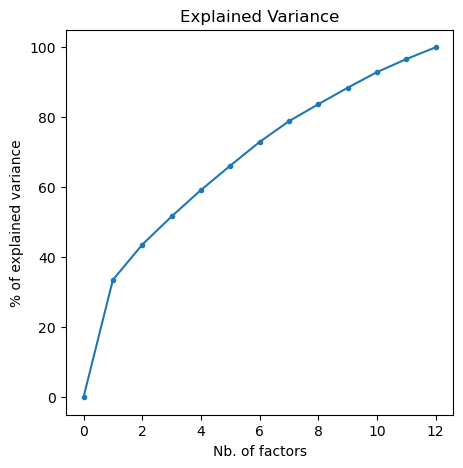

In [22]:
# print explained variance plot

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(range(0,p+1),np.append(0,acp.eig_[2]),".-")
ax.set_xlabel("Nb. of factors")
ax.set_ylabel("% of explained variance")
plt.title("Explained Variance")

plt.show()

In [23]:
# Applying Barlett's test of Sphericity
# import statistical package from scipy
import scipy.stats as stats

# Bartlett's statistic
C = -(n-1-(2*p+5)/6) * np.sum(np.log(acp.eig_[0]))
print(f"Barlett's statistics: {C:.3f}")

# degree of freedom
ddl = p*(p-1)/2

# p-value
print(f"p-value: {1-stats.chi2.cdf(C,df=ddl):.3f}")

Barlett's statistics: 740.640
p-value: 0.000


In [24]:
# Computing Karlis-Saporta-Spinaki threshold
# impor math package
import math

#seuil de Karlis-Saporta-Spinaki
kss = 1+2*math.sqrt((p-1)/(n-1))
print(f"Karlis-Saporta-Spinaki threshold: {kss:.3f}")

Karlis-Saporta-Spinaki threshold: 1.399


thresholds for the broken sticks: [3.10321068 2.10321068 1.60321068 1.26987734 1.01987734 0.81987734
 0.65321068 0.51035354 0.38535354 0.27424242 0.17424242 0.08333333]


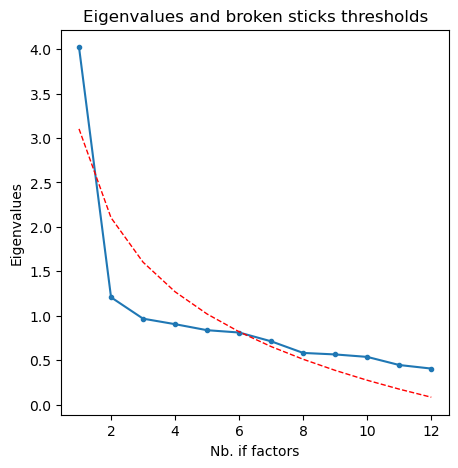

In [25]:
# Broken sticks method
# threshold for the broken sticks
b = np.flip(np.cumsum(1/np.arange(p,0,-1)))
print(f"thresholds for the broken sticks: {b}")

# plot eigenvalues
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(range(1,p+1),acp.eig_[0],".-")
ax.set_xlabel("Nb. if factors")
ax.set_ylabel("Eigenvalues")
plt.title("Eigenvalues and broken sticks thresholds")

# add broken sticks thresholds
ax.plot(range(1,p+1),b,"r--",linewidth=1)

plt.show()

### Variables representation

In [27]:
# Correlation between variables and factors
print(pd.DataFrame(acp.col_coord_[:,:2],index=force_df.columns, columns=['F1','F2']))

               F1        F2
Force1  -0.505822  0.484670
Force4  -0.655021  0.244616
Force6  -0.633068 -0.064147
Force8  -0.556480 -0.014894
Force12 -0.584829 -0.119979
Force13 -0.659243 -0.177454
Force17 -0.528390 -0.538166
Force18 -0.562060 -0.511275
Force19 -0.678872 -0.092309
Force22 -0.607052  0.374804
Force23 -0.459424  0.380205
Force24 -0.463554  0.135600


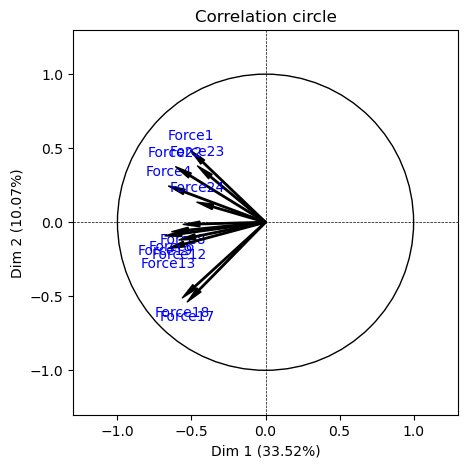

In [28]:
# Correlations circle
acp.correlation_circle(num_x_axis=1,num_y_axis=2, figsize=(5,5))

In [29]:
# Cos² if the variables on the two first factors
print(pd.DataFrame(acp.col_cos2_[:,:2],index=force_df.columns, columns=['F1','F2']))

               F1        F2
Force1   0.255856  0.234905
Force4   0.429053  0.059837
Force6   0.400775  0.004115
Force8   0.309670  0.000222
Force12  0.342025  0.014395
Force13  0.434601  0.031490
Force17  0.279196  0.289623
Force18  0.315911  0.261402
Force19  0.460867  0.008521
Force22  0.368512  0.140478
Force23  0.211070  0.144556
Force24  0.214882  0.018387


In [30]:
# Cumulated Cos² on the two first factors
print(pd.DataFrame(np.cumsum(acp.col_cos2_[:,:2],axis=1),index=force_df.columns, columns=['F1','F2']))

               F1        F2
Force1   0.255856  0.490761
Force4   0.429053  0.488890
Force6   0.400775  0.404890
Force8   0.309670  0.309892
Force12  0.342025  0.356420
Force13  0.434601  0.466091
Force17  0.279196  0.568819
Force18  0.315911  0.577313
Force19  0.460867  0.469387
Force22  0.368512  0.508990
Force23  0.211070  0.355626
Force24  0.214882  0.233270


In [31]:
# Contributions of each variable on the two first factors (in %)
print(pd.DataFrame(acp.col_contrib_[:,:2],index=force_df.columns, columns=['F1','F2']))

                F1         F2
Force1    6.360739  19.446935
Force4   10.666541   4.953686
Force6    9.963534   0.340649
Force8    7.698598   0.018363
Force12   8.502977   1.191709
Force13  10.804479   2.606933
Force17   6.941002  23.976782
Force18   7.853758  21.640455
Force19  11.457447   0.705416
Force22   9.161455  11.629637
Force23   5.247351  11.967207
Force24   5.342119   1.522229


### Individuals representation

In [33]:
# individuals factor coordinates on the first plan (of the two first axes)
print(pd.DataFrame(acp.row_coord_[:,:2],index=force_df.index))

                 0         1
Individu                    
83        0.077168 -0.056030
151       0.077168 -0.056030
177       0.077168 -0.056030
184       0.077168 -0.056030
198       0.077168 -0.056030
...            ...       ...
411      -3.118283  1.106347
421       0.487742  0.523262
100      -0.067389  1.646983
294      -0.404091 -0.304835
395       1.334976  0.063926

[278 rows x 2 columns]


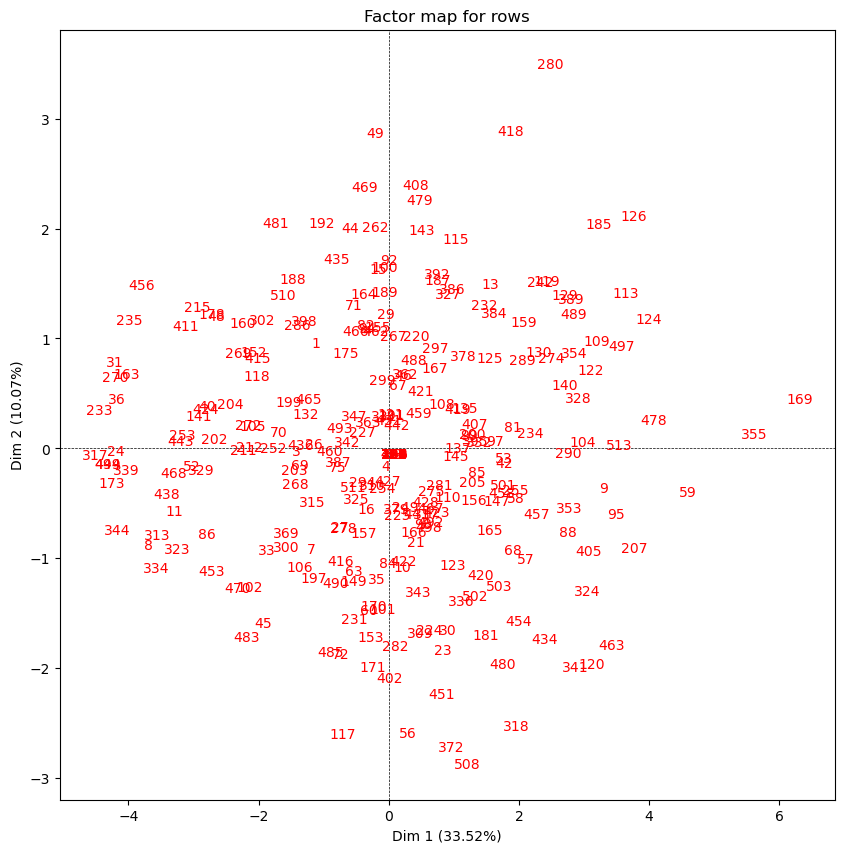

In [34]:
# chart of the individuals
acp.mapping_row(num_x_axis=1,num_y_axis=2,figsize=(10,10))

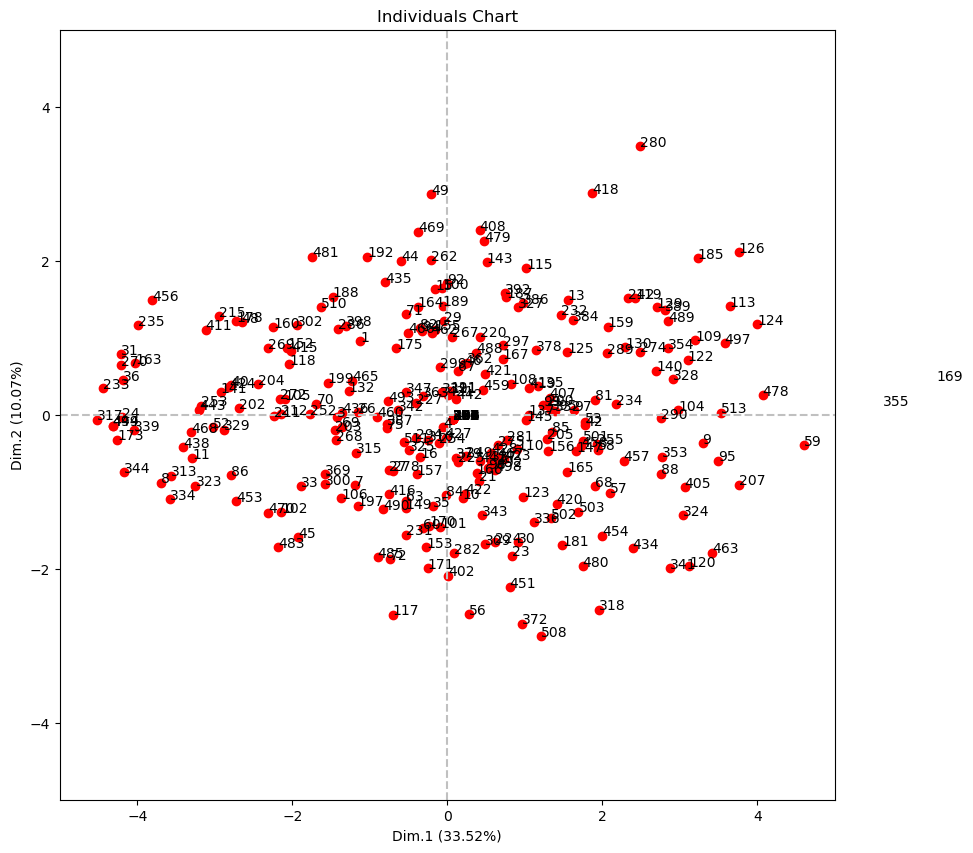

In [35]:
# plot with square scales
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(acp.row_coord_[:, 0], acp.row_coord_[:, 1], 'ro')  
ax.axis([-5, 5, -5, 5])
ax.plot([-5, 5], [0, 0], color='silver', linestyle='--')  
ax.plot([0, 0], [-5, 5], color='silver', linestyle='--')  
ax.set_xlabel("Dim.1 (33.52%)")
ax.set_ylabel("Dim.2 (10.07%)")
plt.title("Individuals Chart")


for i in range(len(force_df)):
    ax.text(acp.row_coord_[i, 0], acp.row_coord_[i, 1], force_df.index[i]) 

plt.show()

In [36]:
# standardized data points
Z = (force_df.values - acp.means_) / acp.std_

# distance to origin from the standardized data
disto = np.apply_along_axis(arr=Z,axis=1,func1d=lambda x: np.sum(x**2))

# distance to origin from the factor coordinates
distoBis = np.sum(acp.row_coord_**2,axis=1)

# compare in a dataframe : distance should be preserved
print(pd.DataFrame(np.transpose(np.array([disto,distoBis])),index=force_df.index, columns=['original','factor']))

           original     factor
Individu                      
83         0.705631   0.705631
151        0.705631   0.705631
177        0.705631   0.705631
184        0.705631   0.705631
198        0.705631   0.705631
...             ...        ...
411       19.569414  19.569414
421        7.994796   7.994796
100        7.029969   7.029969
294       12.700948  12.700948
395       12.161999  12.161999

[278 rows x 2 columns]


In [37]:
# cos² of the individuals
lig_cos2 = np.apply_along_axis(arr=acp.row_coord_[:,:2],axis=0,func1d=lambda x: (x**2)/disto)
print(pd.DataFrame(lig_cos2,index=force_df.index, columns=['F1','F2']))

                F1        F2
Individu                    
83        0.008439  0.004449
151       0.008439  0.004449
177       0.008439  0.004449
184       0.008439  0.004449
198       0.008439  0.004449
...            ...       ...
411       0.496882  0.062547
421       0.029756  0.034248
100       0.000646  0.385856
294       0.012856  0.007316
395       0.146535  0.000336

[278 rows x 2 columns]


In [38]:
# or directly with fanalysis.pca
print(pd.DataFrame(acp.row_cos2_[:,:2],index=force_df.index, columns=['F1','F2']))

                F1        F2
Individu                    
83        0.008439  0.004449
151       0.008439  0.004449
177       0.008439  0.004449
184       0.008439  0.004449
198       0.008439  0.004449
...            ...       ...
411       0.496882  0.062547
421       0.029756  0.034248
100       0.000646  0.385856
294       0.012856  0.007316
395       0.146535  0.000336

[278 rows x 2 columns]


In [39]:
dir(acp)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_tags__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_compute_stats',
 '_compute_svd',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_sklearn_auto_wrap_output_keys',
 '_validate_data',
 '_validate_params',
 'col_contrib_',
 'col_coord_',
 'col_cor_',
 'col_cos2_',
 'col_labels',
 'col_labels_',
 'col_labels_sh

In [40]:
# cumulated Cos² on the two first axes
print(pd.DataFrame(np.cumsum(acp.row_cos2_[:,:2],axis=1),index=force_df.index, columns=['F1','F2']))

                F1        F2
Individu                    
83        0.008439  0.012888
151       0.008439  0.012888
177       0.008439  0.012888
184       0.008439  0.012888
198       0.008439  0.012888
...            ...       ...
411       0.496882  0.559429
421       0.029756  0.064004
100       0.000646  0.386502
294       0.012856  0.020173
395       0.146535  0.146871

[278 rows x 2 columns]


In [41]:
# contributions on the two first factors
lig_ctr = (acp.row_coord_[:,:2]**2)/(n*acp.eig_[0][:2])*100
print(pd.DataFrame(lig_ctr,index=force_df.index, columns=['F1','F2']))

                F1        F2
Individu                    
83        0.000533  0.000935
151       0.000533  0.000935
177       0.000533  0.000935
184       0.000533  0.000935
198       0.000533  0.000935
...            ...       ...
411       0.869559  0.364499
421       0.021274  0.081536
100       0.000406  0.807777
294       0.014602  0.027672
395       0.159373  0.001217

[278 rows x 2 columns]


In [42]:
# check with fanalysis.pca
print(pd.DataFrame(acp.row_contrib_[:,:2],index=force_df.index, columns=['F1','F2']))

                F1        F2
Individu                    
83        0.000533  0.000935
151       0.000533  0.000935
177       0.000533  0.000935
184       0.000533  0.000935
198       0.000533  0.000935
...            ...       ...
411       0.869559  0.364499
421       0.021274  0.081536
100       0.000406  0.807777
294       0.014602  0.027672
395       0.159373  0.001217

[278 rows x 2 columns]


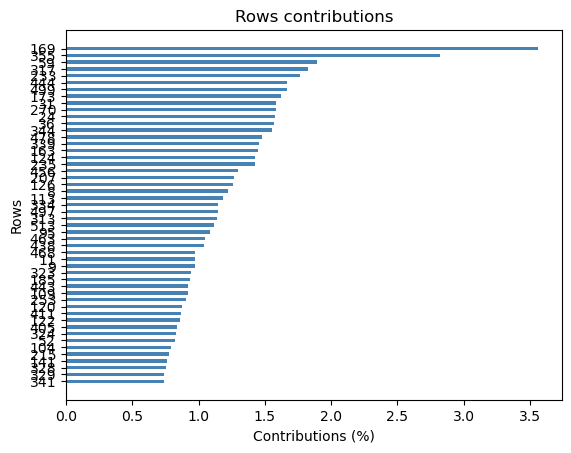

In [43]:
# plot : contributions to the first factor
acp.plot_row_contrib(num_axis=1,nb_values=50)

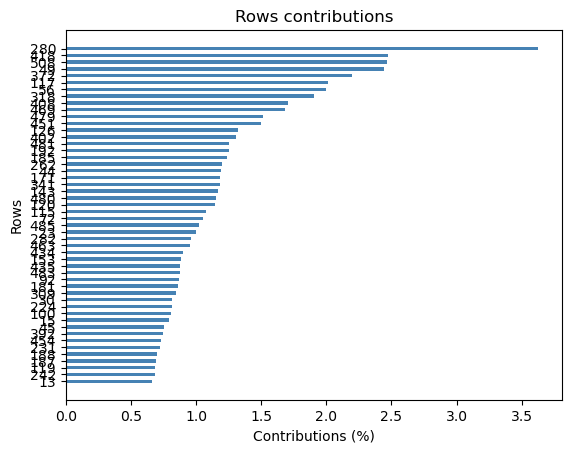

In [44]:
# plot : contributions to the second factor
acp.plot_row_contrib(num_axis=2,nb_values=50)

### Transition relationships

In [46]:
# Coordinates of individuals from variables - Factor 1
f1 = 1/math.sqrt(acp.eig_[0][0]) * np.dot(Z,acp.col_coord_[:,0])

# print and check coordinates
print(pd.DataFrame(np.transpose(np.array([f1,acp.row_coord_[:,0]])),index=force_df.index, columns=['transition','actual']))

          transition    actual
Individu                      
83          0.077168  0.077168
151         0.077168  0.077168
177         0.077168  0.077168
184         0.077168  0.077168
198         0.077168  0.077168
...              ...       ...
411        -3.118283 -3.118283
421         0.487742  0.487742
100        -0.067389 -0.067389
294        -0.404091 -0.404091
395         1.334976  1.334976

[278 rows x 2 columns]


In [47]:
# Coordinates of variables from individuals - Factor 1
r1 = 1/(n*math.sqrt(acp.eig_[0][0])) * np.dot(np.transpose(Z),acp.row_coord_[:,0])

# print and check correlations
print(pd.DataFrame(np.transpose(np.array([r1,acp.col_coord_[:,0]])),index=force_df.columns, columns=['transition','actual']))

         transition    actual
Force1    -0.505822 -0.505822
Force4    -0.655021 -0.655021
Force6    -0.633068 -0.633068
Force8    -0.556480 -0.556480
Force12   -0.584829 -0.584829
Force13   -0.659243 -0.659243
Force17   -0.528390 -0.528390
Force18   -0.562060 -0.562060
Force19   -0.678872 -0.678872
Force22   -0.607052 -0.607052
Force23   -0.459424 -0.459424
Force24   -0.463554 -0.463554


In [48]:
# launch all the basic modules
import os
import pandas
import pandas as pd
import numpy
import numpy as np

In [49]:
# dummy coding (one hot encoding)
X = pandas.get_dummies(force_df,prefix='',prefix_sep='')
print(X)

# define M = total number of modalities
M = X.shape[1]

          Force1  Force4  Force6  Force8  Force12  Force13  Force17  Force18  \
Individu                                                                       
83           4.0     4.0     5.0     4.0      4.0      4.0      5.0      4.0   
151          4.0     4.0     5.0     4.0      4.0      4.0      5.0      4.0   
177          4.0     4.0     5.0     4.0      4.0      4.0      5.0      4.0   
184          4.0     4.0     5.0     4.0      4.0      4.0      5.0      4.0   
198          4.0     4.0     5.0     4.0      4.0      4.0      5.0      4.0   
...          ...     ...     ...     ...      ...      ...      ...      ...   
411          6.0     6.0     6.0     6.0      3.0      6.0      5.0      4.0   
421          3.0     4.0     5.0     5.0      2.0      4.0      5.0      3.0   
100          5.0     5.0     5.0     3.0      3.0      5.0      3.0      4.0   
294          6.0     2.0     6.0     6.0      4.0      5.0      4.0      5.0   
395          3.0     4.0     5.0     5.0

## Flux_df

In [51]:
# print dataset summary
print(flux_df.info())

# define dimensions of [X] matrix : number of variables
p = flux_df.shape[1]

# define sample size of [X] : number of observations
n = flux_df.shape[0]

# define values of matrix [X]
X = flux_df.values

<class 'pandas.core.frame.DataFrame'>
Index: 278 entries, 83 to 395
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Flux1   278 non-null    float64
 1   Flux2   278 non-null    float64
 2   Flux3   278 non-null    float64
 3   Flux4   278 non-null    float64
 4   Flux5   278 non-null    float64
 5   Flux6   278 non-null    float64
 6   Flux7   278 non-null    float64
 7   Flux8   278 non-null    float64
 8   Flux9   278 non-null    float64
dtypes: float64(9)
memory usage: 21.7 KB
None


In [52]:
# import PCA module from fanalysis package
from fanalysis.pca import PCA

# instantiate acp object form PCA class
acp = PCA(std_unit=True,row_labels=flux_df.index,col_labels=flux_df.columns)

# run PCA on X observed data
acp.fit(X)

# print methods and attributes of acp object
print(dir(acp))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_clone__', '__sklearn_tags__', '__str__', '__subclasshook__', '__weakref__', '_build_request_for_signature', '_check_feature_names', '_check_n_features', '_compute_stats', '_compute_svd', '_doc_link_module', '_doc_link_template', '_doc_link_url_param_generator', '_get_default_requests', '_get_doc_link', '_get_metadata_request', '_get_param_names', '_get_tags', '_more_tags', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_sklearn_auto_wrap_output_keys', '_validate_data', '_validate_params', 'col_contrib_', 'col_coord_', 'col_cor_', 'col_cos2_', 'col_labels', 'col_labels_', 'col_labels_short_', 'col_topandas', 'correlation_circle', 'eig_', 'ei

In [53]:
acp.col_labels

Index(['Flux1', 'Flux2', 'Flux3', 'Flux4', 'Flux5', 'Flux6', 'Flux7', 'Flux8',
       'Flux9'],
      dtype='object')

In [54]:
acp.row_labels

Index([ 83, 151, 177, 184, 198, 206, 226, 230, 246, 258,
       ...
       341, 467, 342,  84, 334, 411, 421, 100, 294, 395],
      dtype='int64', name='Individu', length=278)

In [55]:
# print eigenvalues (the lambdas) - output includes proportion of variance explained and cumulated values thereof
print(acp.eig_)

[[  3.47569485   1.76024085   0.89794685   0.75622721   0.63017835
    0.51622642   0.39521135   0.29292973   0.27534439]
 [ 38.61883164  19.5582317    9.97718722   8.40252456   7.00198171
    5.73584915   4.39123718   3.25477476   3.05938208]
 [ 38.61883164  58.17706333  68.15425055  76.55677511  83.55875683
   89.29460598  93.68584316  96.94061792 100.        ]]


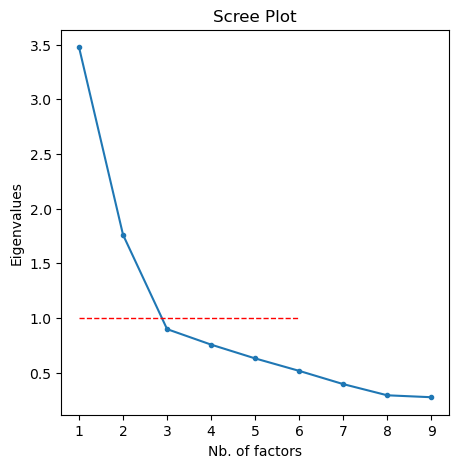

In [56]:
# print scree plot

# first the main plot
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(range(1,p+1),acp.eig_[0],".-")
ax.set_xlabel("Nb. of factors")
ax.set_ylabel("Eigenvalues")
plt.title("Scree Plot")

# add Kaiser's threshold line
ax.plot([1,6],[1,1],"r--",linewidth=1)

plt.show()

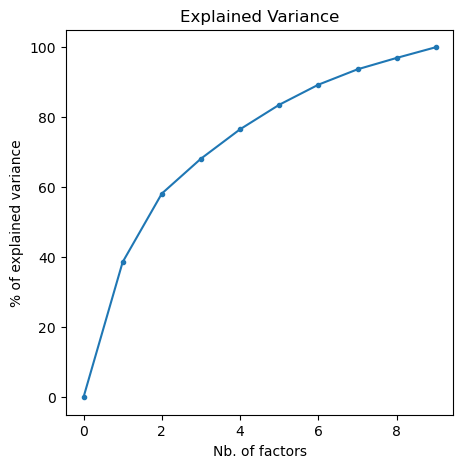

In [57]:
# print explained variance plot

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(range(0,p+1),np.append(0,acp.eig_[2]),".-")
ax.set_xlabel("Nb. of factors")
ax.set_ylabel("% of explained variance")
plt.title("Explained Variance")

plt.show()

In [58]:
# Applying Barlett's test of Sphericity
# import statistical package from scipy
import scipy.stats as stats

# Bartlett's statistic
C = -(n-1-(2*p+5)/6) * np.sum(np.log(acp.eig_[0]))
print(f"Barlett's statistics: {C:.3f}")

# degree of freedom
ddl = p*(p-1)/2

# p-value
print(f"p-value: {1-stats.chi2.cdf(C,df=ddl):.3f}")

Barlett's statistics: 859.018
p-value: 0.000


In [59]:
# Computing Karlis-Saporta-Spinaki threshold
# impor math package
import math

#seuil de Karlis-Saporta-Spinaki
kss = 1+2*math.sqrt((p-1)/(n-1))
print(f"Karlis-Saporta-Spinaki threshold: {kss:.3f}")

Karlis-Saporta-Spinaki threshold: 1.340


thresholds for the broken sticks: [2.82896825 1.82896825 1.32896825 0.99563492 0.74563492 0.54563492
 0.37896825 0.23611111 0.11111111]


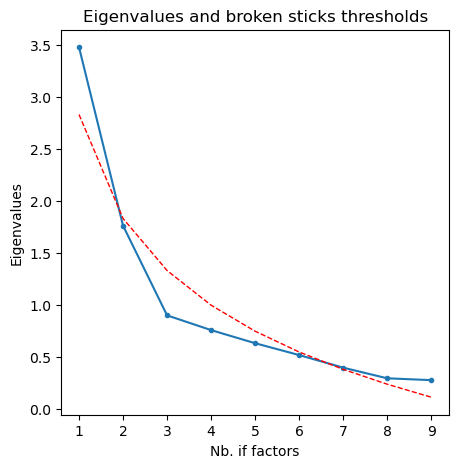

In [60]:
# Broken sticks method
# threshold for the broken sticks
b = np.flip(np.cumsum(1/np.arange(p,0,-1)))
print(f"thresholds for the broken sticks: {b}")

# plot eigenvalues
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(range(1,p+1),acp.eig_[0],".-")
ax.set_xlabel("Nb. if factors")
ax.set_ylabel("Eigenvalues")
plt.title("Eigenvalues and broken sticks thresholds")

# add broken sticks thresholds
ax.plot(range(1,p+1),b,"r--",linewidth=1)

plt.show()

### Variables representation

In [62]:
# Correlation between variables and factors
print(pd.DataFrame(acp.col_coord_[:,:2],index=flux_df.columns, columns=['F1','F2']))

             F1        F2
Flux1  0.423604 -0.214130
Flux2  0.645083 -0.334195
Flux3  0.785692 -0.094186
Flux4  0.490050  0.708373
Flux5  0.371038  0.771399
Flux6  0.432920  0.580080
Flux7  0.791037 -0.247782
Flux8  0.752679 -0.146138
Flux9  0.710849 -0.278815


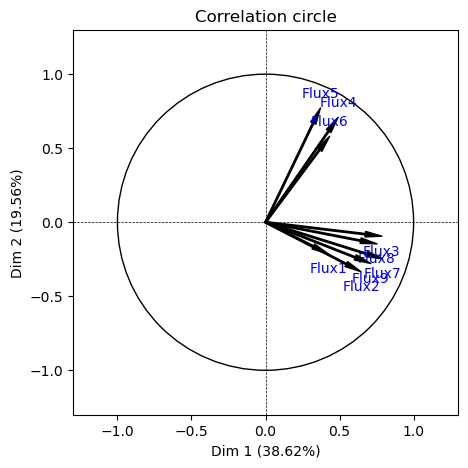

In [63]:
# Correlations circle
acp.correlation_circle(num_x_axis=1,num_y_axis=2, figsize=(5,5))

In [64]:
# Cos² if the variables on the two first factors
print(pd.DataFrame(acp.col_cos2_[:,:2],index=flux_df.columns, columns=['F1','F2']))

             F1        F2
Flux1  0.179441  0.045852
Flux2  0.416132  0.111686
Flux3  0.617313  0.008871
Flux4  0.240149  0.501793
Flux5  0.137669  0.595056
Flux6  0.187420  0.336493
Flux7  0.625739  0.061396
Flux8  0.566526  0.021356
Flux9  0.505307  0.077738


In [65]:
# Cumulated Cos² on the two first factors
print(pd.DataFrame(np.cumsum(acp.col_cos2_[:,:2],axis=1),index=flux_df.columns, columns=['F1','F2']))

             F1        F2
Flux1  0.179441  0.225292
Flux2  0.416132  0.527818
Flux3  0.617313  0.626183
Flux4  0.240149  0.741942
Flux5  0.137669  0.732725
Flux6  0.187420  0.523913
Flux7  0.625739  0.687135
Flux8  0.566526  0.587882
Flux9  0.505307  0.583044


In [66]:
# Contributions of each variable on the two first factors (in %)
print(pd.DataFrame(acp.col_contrib_[:,:2],index=flux_df.columns, columns=['F1','F2']))

              F1         F2
Flux1   5.162724   2.604863
Flux2  11.972622   6.344936
Flux3  17.760838   0.503962
Flux4   6.909393  28.507040
Flux5   3.960901  33.805394
Flux6   5.392305  19.116326
Flux7  18.003277   3.487914
Flux8  16.299646   1.213255
Flux9  14.538293   4.416311


### Individuals representation

In [68]:
# individuals factor coordinates on the first plan (of the two first axes)
print(pd.DataFrame(acp.row_coord_[:,:2],index=flux_df.index))

                 0         1
Individu                    
83        0.432349  0.393149
151       0.432349  0.393149
177       0.432349  0.393149
184       0.432349  0.393149
198       0.432349  0.393149
...            ...       ...
411       2.930436  1.293413
421      -0.029322  0.966685
100       0.548347  1.082250
294       3.343596  0.505634
395       3.136148  0.544531

[278 rows x 2 columns]


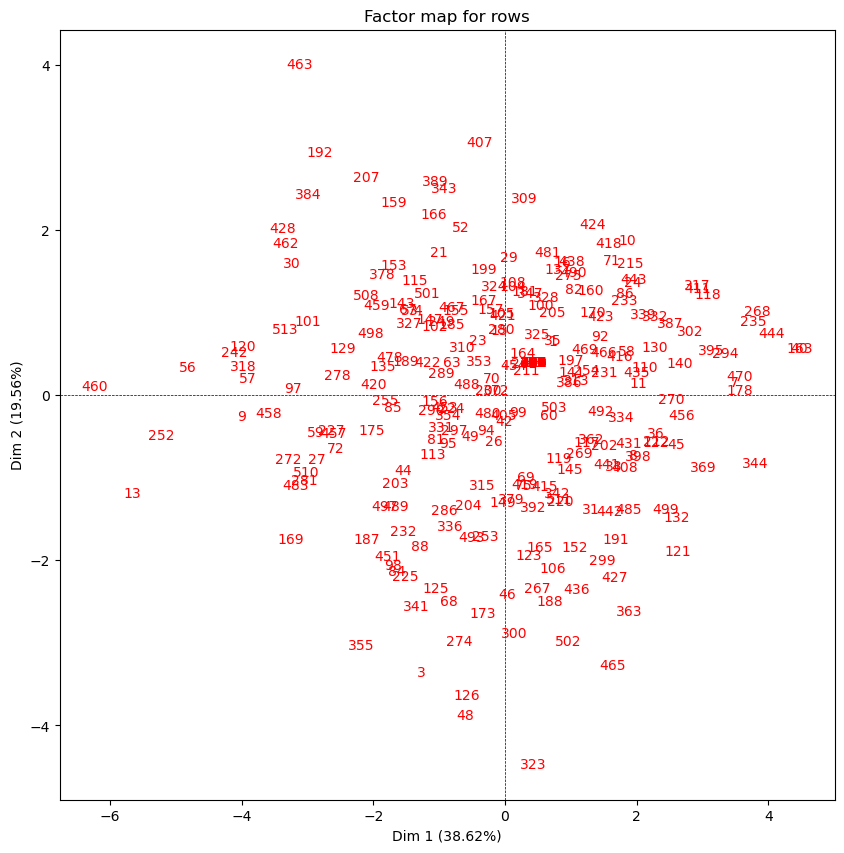

In [69]:
# chart of the individuals
acp.mapping_row(num_x_axis=1,num_y_axis=2,figsize=(10,10))

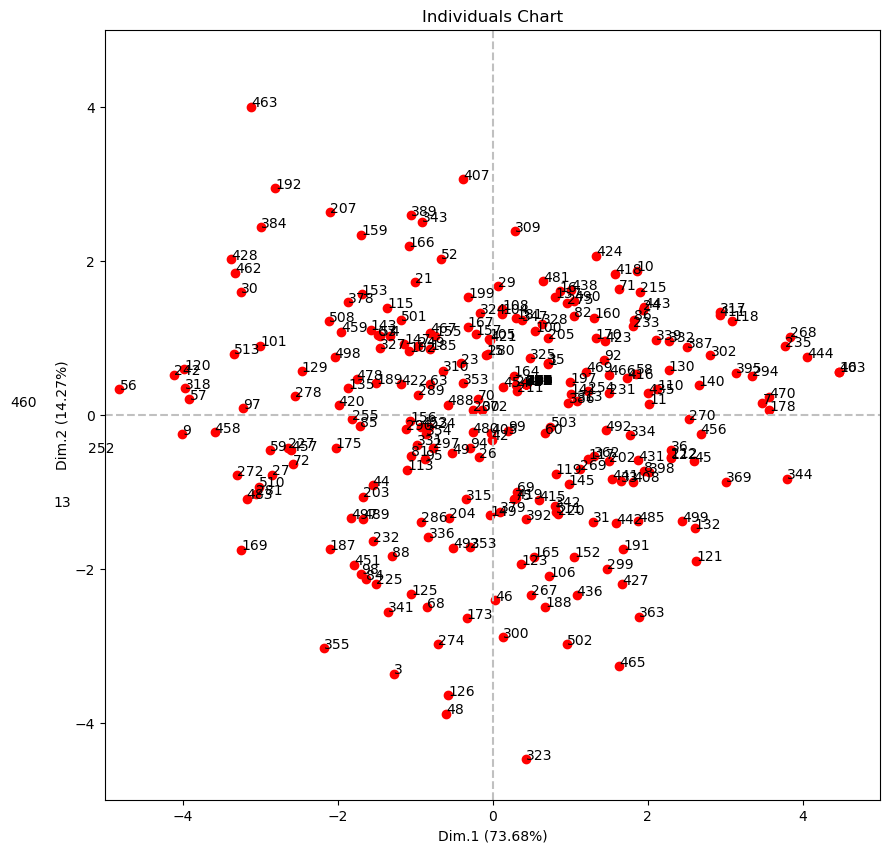

In [70]:
# plot with square scales
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(acp.row_coord_[:,0],acp.row_coord_[:,1],'ro')
ax.axis([-5,+5,-5,+5])
ax.plot([-5,+5],[0,0],color='silver',linestyle='--')
ax.plot([0,0],[-5,+5],color='silver',linestyle='--')
ax.set_xlabel("Dim.1 (73.68%)")
ax.set_ylabel("Dim.2 (14.27%)")
plt.title("Individuals Chart")

for i in range(n):
    ax.text(acp.row_coord_[i,0],acp.row_coord_[i,1],flux_df.index[i])
    
plt.show()

In [71]:
# standardized data points
Z = (flux_df.values - acp.means_) / acp.std_

# distance to origin from the standardized data
disto = np.apply_along_axis(arr=Z,axis=1,func1d=lambda x: np.sum(x**2))

# distance to origin from the factor coordinates
distoBis = np.sum(acp.row_coord_**2,axis=1)

# compare in a dataframe : distance should be preserved
print(pd.DataFrame(np.transpose(np.array([disto,distoBis])),index=flux_df.index, columns=['original','factor']))

           original     factor
Individu                      
83         0.900683   0.900683
151        0.900683   0.900683
177        0.900683   0.900683
184        0.900683   0.900683
198        0.900683   0.900683
...             ...        ...
411       11.675651  11.675651
421        3.850895   3.850895
100        7.151207   7.151207
294       18.399373  18.399373
395       11.520464  11.520464

[278 rows x 2 columns]


In [72]:
# cos² of the individuals
lig_cos2 = np.apply_along_axis(arr=acp.row_coord_[:,:2],axis=0,func1d=lambda x: (x**2)/disto)
print(pd.DataFrame(lig_cos2,index=flux_df.index, columns=['F1','F2']))

                F1        F2
Individu                    
83        0.207538  0.171610
151       0.207538  0.171610
177       0.207538  0.171610
184       0.207538  0.171610
198       0.207538  0.171610
...            ...       ...
411       0.735501  0.143283
421       0.000223  0.242666
100       0.042047  0.163786
294       0.607610  0.013895
395       0.853735  0.025738

[278 rows x 2 columns]


In [73]:
# cos² of the individuals
lig_cos2 = np.apply_along_axis(arr=acp.row_coord_[:,:2],axis=0,func1d=lambda x: (x**2)/disto)
print(pd.DataFrame(lig_cos2,index=flux_df.index, columns=['F1','F2']))

                F1        F2
Individu                    
83        0.207538  0.171610
151       0.207538  0.171610
177       0.207538  0.171610
184       0.207538  0.171610
198       0.207538  0.171610
...            ...       ...
411       0.735501  0.143283
421       0.000223  0.242666
100       0.042047  0.163786
294       0.607610  0.013895
395       0.853735  0.025738

[278 rows x 2 columns]


In [74]:
dir(acp)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_tags__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_compute_stats',
 '_compute_svd',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_sklearn_auto_wrap_output_keys',
 '_validate_data',
 '_validate_params',
 'col_contrib_',
 'col_coord_',
 'col_cor_',
 'col_cos2_',
 'col_labels',
 'col_labels_',
 'col_labels_sh

In [75]:
# cumulated Cos² on the two first axes
print(pd.DataFrame(np.cumsum(acp.row_cos2_[:,:2],axis=1),index=flux_df.index, columns=['F1','F2']))

                F1        F2
Individu                    
83        0.207538  0.379148
151       0.207538  0.379148
177       0.207538  0.379148
184       0.207538  0.379148
198       0.207538  0.379148
...            ...       ...
411       0.735501  0.878784
421       0.000223  0.242889
100       0.042047  0.205832
294       0.607610  0.621505
395       0.853735  0.879473

[278 rows x 2 columns]


In [76]:
# contributions on the two first factors
lig_ctr = (acp.row_coord_[:,:2]**2)/(n*acp.eig_[0][:2])*100
print(pd.DataFrame(lig_ctr,index=flux_df.index, columns=['F1','F2']))

                F1        F2
Individu                    
83        0.019346  0.031586
151       0.019346  0.031586
177       0.019346  0.031586
184       0.019346  0.031586
198       0.019346  0.031586
...            ...       ...
411       0.888747  0.341867
421       0.000089  0.190965
100       0.031119  0.239353
294       1.157021  0.052246
395       1.017903  0.060594

[278 rows x 2 columns]


In [77]:
# check with fanalysis.pca
print(pandas.DataFrame(acp.row_contrib_[:,:2],index=flux_df.index, columns=['F1','F2']))

                F1        F2
Individu                    
83        0.019346  0.031586
151       0.019346  0.031586
177       0.019346  0.031586
184       0.019346  0.031586
198       0.019346  0.031586
...            ...       ...
411       0.888747  0.341867
421       0.000089  0.190965
100       0.031119  0.239353
294       1.157021  0.052246
395       1.017903  0.060594

[278 rows x 2 columns]


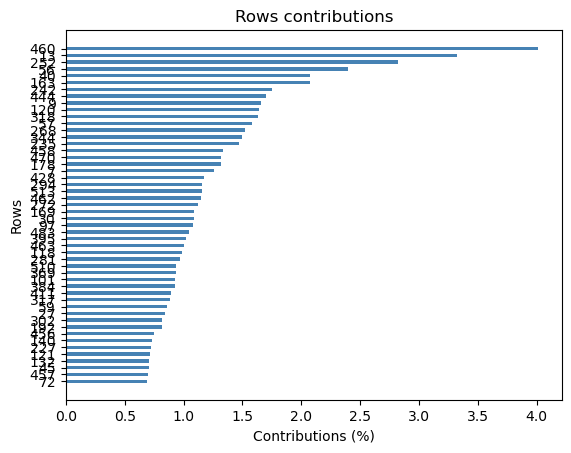

In [78]:
# plot : contributions to the first factor
acp.plot_row_contrib(num_axis=1,nb_values=50)

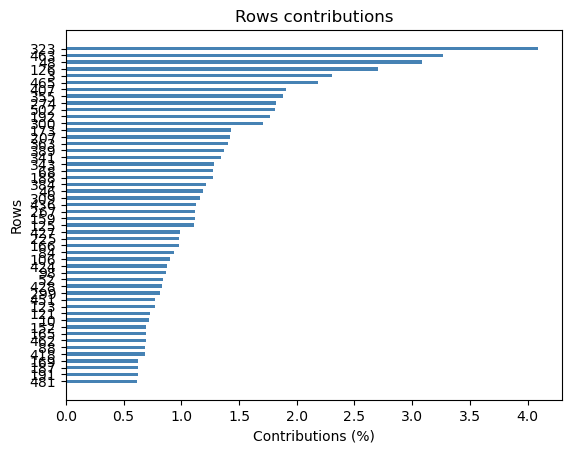

In [79]:
# plot : contributions to the second factor
acp.plot_row_contrib(num_axis=2,nb_values=50)

### Trasition relationships

In [81]:
# Coordinates of individuals from variables - Factor 1
f1 = 1/math.sqrt(acp.eig_[0][0]) * np.dot(Z,acp.col_coord_[:,0])

# print and check coordinates
print(pd.DataFrame(np.transpose(np.array([f1,acp.row_coord_[:,0]])),index=flux_df.index, columns=['transition','actual']))

          transition    actual
Individu                      
83          0.432349  0.432349
151         0.432349  0.432349
177         0.432349  0.432349
184         0.432349  0.432349
198         0.432349  0.432349
...              ...       ...
411         2.930436  2.930436
421        -0.029322 -0.029322
100         0.548347  0.548347
294         3.343596  3.343596
395         3.136148  3.136148

[278 rows x 2 columns]


In [82]:
# Coordinates of variables from individuals - Factor 1
r1 = 1/(n*math.sqrt(acp.eig_[0][0])) * np.dot(np.transpose(Z),acp.row_coord_[:,0])

# print and check correlations
print(pd.DataFrame(np.transpose(np.array([r1,acp.col_coord_[:,0]])),index=flux_df.columns, columns=['transition','actual']))

       transition    actual
Flux1    0.423604  0.423604
Flux2    0.645083  0.645083
Flux3    0.785692  0.785692
Flux4    0.490050  0.490050
Flux5    0.371038  0.371038
Flux6    0.432920  0.432920
Flux7    0.791037  0.791037
Flux8    0.752679  0.752679
Flux9    0.710849  0.710849


## Fq_df

In [84]:
# print dataset summary
print(fq_df.info())

# define dimensions of [X] matrix : number of variables
p = fq_df.shape[1]

# define sample size of [X] : number of observations
n = fq_df.shape[0]

# define values of matrix [X]
X = fq_df.values

<class 'pandas.core.frame.DataFrame'>
Index: 278 entries, 83 to 395
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FQ1     278 non-null    float64
 1   FQ2     278 non-null    float64
 2   FQ3     278 non-null    float64
dtypes: float64(3)
memory usage: 8.7 KB
None


In [85]:
# import PCA module from fanalysis package
from fanalysis.pca import PCA

# instantiate acp object form PCA class
acp = PCA(std_unit=True,row_labels=fq_df.index,col_labels=fq_df.columns)

# run PCA on X observed data
acp.fit(X)

# print methods and attributes of acp object
print(dir(acp))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_clone__', '__sklearn_tags__', '__str__', '__subclasshook__', '__weakref__', '_build_request_for_signature', '_check_feature_names', '_check_n_features', '_compute_stats', '_compute_svd', '_doc_link_module', '_doc_link_template', '_doc_link_url_param_generator', '_get_default_requests', '_get_doc_link', '_get_metadata_request', '_get_param_names', '_get_tags', '_more_tags', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_sklearn_auto_wrap_output_keys', '_validate_data', '_validate_params', 'col_contrib_', 'col_coord_', 'col_cor_', 'col_cos2_', 'col_labels', 'col_labels_', 'col_labels_short_', 'col_topandas', 'correlation_circle', 'eig_', 'ei

In [86]:
acp.col_labels

Index(['FQ1', 'FQ2', 'FQ3'], dtype='object')

In [87]:
acp.row_labels

Index([ 83, 151, 177, 184, 198, 206, 226, 230, 246, 258,
       ...
       341, 467, 342,  84, 334, 411, 421, 100, 294, 395],
      dtype='int64', name='Individu', length=278)

### Determine the number of factors

In [89]:
# print eigenvalues (the lambdas) - output includes proportion of variance explained and cumulated values thereof
print(acp.eig_)

[[  1.87328711   0.67907107   0.44764182]
 [ 62.44290366  22.63570227  14.92139407]
 [ 62.44290366  85.07860593 100.        ]]


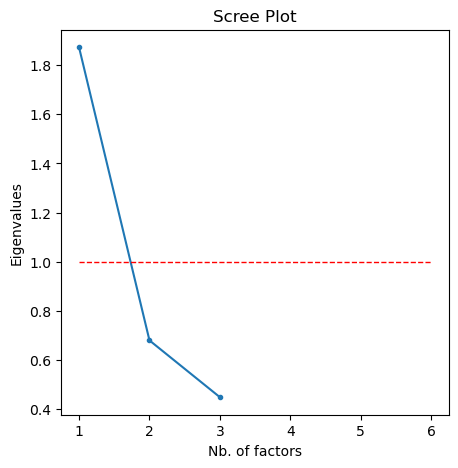

In [90]:
# print scree plot

# first the main plot
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(range(1,p+1),acp.eig_[0],".-")
ax.set_xlabel("Nb. of factors")
ax.set_ylabel("Eigenvalues")
plt.title("Scree Plot")

# add Kaiser's threshold line
ax.plot([1,6],[1,1],"r--",linewidth=1)

plt.show()

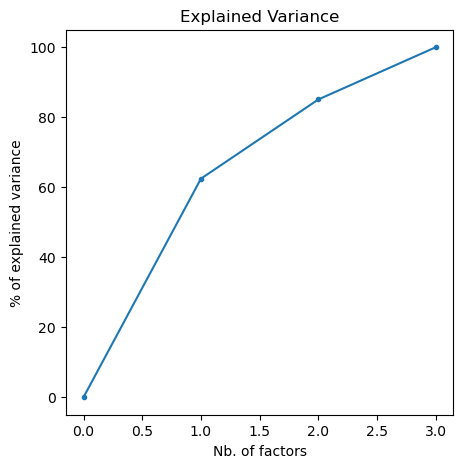

In [91]:
# print explained variance plot

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(range(0,p+1),np.append(0,acp.eig_[2]),".-")
ax.set_xlabel("Nb. of factors")
ax.set_ylabel("% of explained variance")
plt.title("Explained Variance")

plt.show()

In [92]:
# Applying Barlett's test of Sphericity
# import statistical package from scipy
import scipy.stats as stats

# Bartlett's statistic
C = -(n-1-(2*p+5)/6) * np.sum(np.log(acp.eig_[0]))
print(f"Barlett's statistics: {C:.3f}")

# degree of freedom
ddl = p*(p-1)/2

# p-value
print(f"p-value: {1-stats.chi2.cdf(C,df=ddl):.3f}")

Barlett's statistics: 154.945
p-value: 0.000


In [93]:
# Computing Karlis-Saporta-Spinaki threshold
# impor math package
import math

#seuil de Karlis-Saporta-Spinaki
kss = 1+2*math.sqrt((p-1)/(n-1))
print(f"Karlis-Saporta-Spinaki threshold: {kss:.3f}")

Karlis-Saporta-Spinaki threshold: 1.170


thresholds for the broken sticks: [1.83333333 0.83333333 0.33333333]


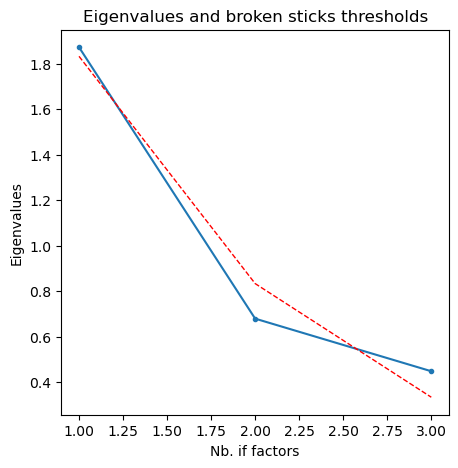

In [94]:
# Broken sticks method
# threshold for the broken sticks
b = np.flip(np.cumsum(1/np.arange(p,0,-1)))
print(f"thresholds for the broken sticks: {b}")

# plot eigenvalues
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(range(1,p+1),acp.eig_[0],".-")
ax.set_xlabel("Nb. if factors")
ax.set_ylabel("Eigenvalues")
plt.title("Eigenvalues and broken sticks thresholds")

# add broken sticks thresholds
ax.plot(range(1,p+1),b,"r--",linewidth=1)

plt.show()

### Variables representation

In [96]:
# Correlation between variables and factors
print(pandas.DataFrame(acp.col_coord_[:,:2],index=fq_df.columns, columns=['F1','F2']))

           F1        F2
FQ1  0.841180 -0.201657
FQ2  0.715640  0.690729
FQ3  0.808432 -0.401620


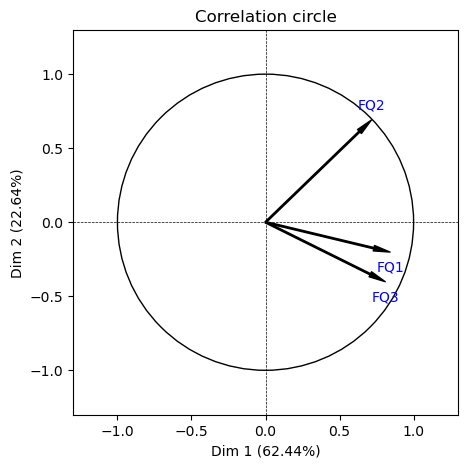

In [97]:
# Correlations circle
acp.correlation_circle(num_x_axis=1,num_y_axis=2, figsize=(5,5))

In [98]:
# Cos² if the variables on the two first factors
print(pandas.DataFrame(acp.col_cos2_[:,:2],index=fq_df.columns, columns=['F1','F2']))

           F1        F2
FQ1  0.707584  0.040666
FQ2  0.512140  0.477106
FQ3  0.653563  0.161299


In [99]:
# Cumulated Cos² on the two first factors
print(pandas.DataFrame(np.cumsum(acp.col_cos2_[:,:2],axis=1),index=fq_df.columns, columns=['F1','F2']))

           F1        F2
FQ1  0.707584  0.748250
FQ2  0.512140  0.989247
FQ3  0.653563  0.814862


In [100]:
# Contributions of each variable on the two first factors (in %)
print(pandas.DataFrame(acp.col_contrib_[:,:2],index=fq_df.columns, columns=['F1','F2']))

            F1         F2
FQ1  37.772312   5.988437
FQ2  27.339131  70.258687
FQ3  34.888558  23.752876


### Individuals representation

In [102]:
# individuals factor coordinates on the first plan (of the two first axes)
print(pandas.DataFrame(acp.row_coord_[:,:2],index=fq_df.index))

                 0         1
Individu                    
83        0.048560 -0.397135
151       0.048560 -0.397135
177       0.048560 -0.397135
184       0.048560 -0.397135
198       0.048560 -0.397135
...            ...       ...
411       3.325444  1.196982
421      -2.695848  0.351784
100       1.699506 -0.243819
294       0.048560 -0.397135
395       1.117012 -0.011886

[278 rows x 2 columns]


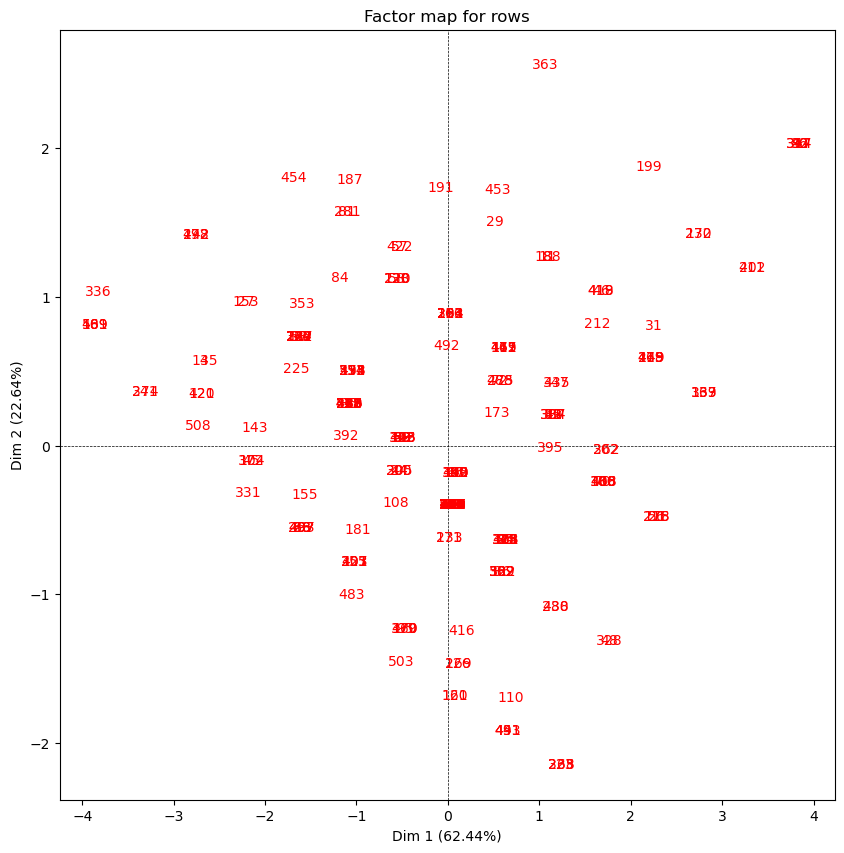

In [103]:
# chart of the individuals
acp.mapping_row(num_x_axis=1,num_y_axis=2,figsize=(10,10))

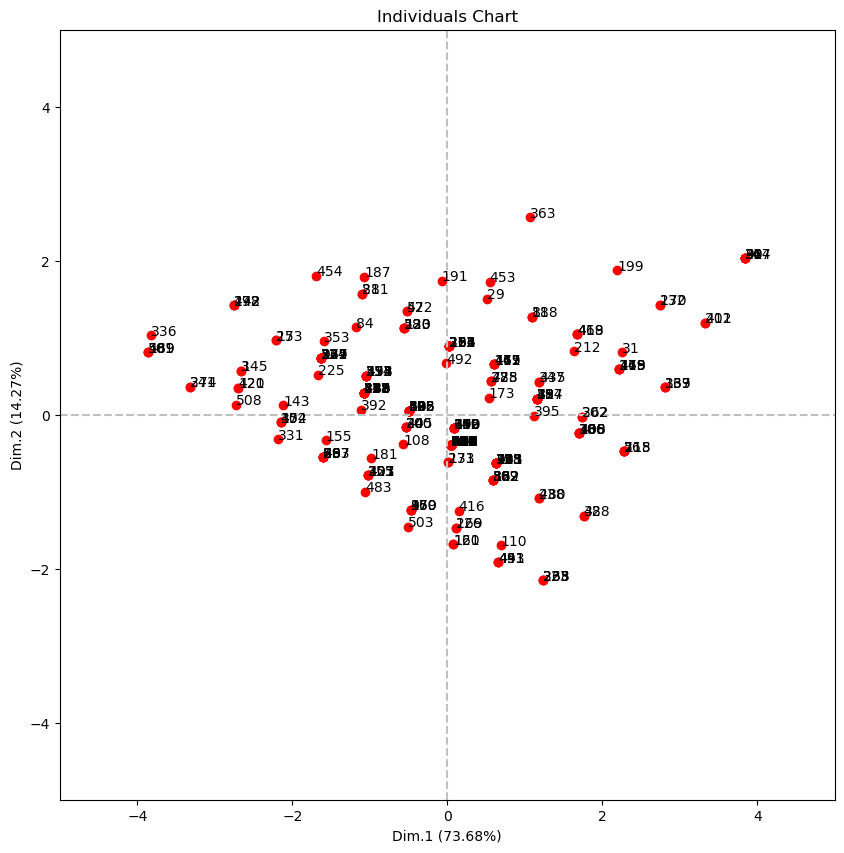

In [104]:
# plot with square scales
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(acp.row_coord_[:,0],acp.row_coord_[:,1],'ro')
ax.axis([-5,+5,-5,+5])
ax.plot([-5,+5],[0,0],color='silver',linestyle='--')
ax.plot([0,0],[-5,+5],color='silver',linestyle='--')
ax.set_xlabel("Dim.1 (73.68%)")
ax.set_ylabel("Dim.2 (14.27%)")
plt.title("Individuals Chart")

for i in range(n):
    ax.text(acp.row_coord_[i,0],acp.row_coord_[i,1],fq_df.index[i])
    
plt.show()

In [105]:
# standardized data points
Z = (fq_df.values - acp.means_) / acp.std_

# distance to origin from the standardized data
disto = np.apply_along_axis(arr=Z,axis=1,func1d=lambda x: np.sum(x**2))

# distance to origin from the factor coordinates
distoBis = np.sum(acp.row_coord_**2,axis=1)

# compare in a dataframe : distance should be preserved
print(pandas.DataFrame(np.transpose(np.array([disto,distoBis])),index=fq_df.index, columns=['original','factor']))

           original     factor
Individu                      
83         0.210224   0.210224
151        0.210224   0.210224
177        0.210224   0.210224
184        0.210224   0.210224
198        0.210224   0.210224
...             ...        ...
411       12.510491  12.510491
421        8.402902   8.402902
100        3.016990   3.016990
294        0.210224   0.210224
395        2.196264   2.196264

[278 rows x 2 columns]


In [106]:
# cos² of the individuals
lig_cos2 = np.apply_along_axis(arr=acp.row_coord_[:,:2],axis=0,func1d=lambda x: (x**2)/disto)
print(pandas.DataFrame(lig_cos2,index=fq_df.index, columns=['F1','F2']))

                F1        F2
Individu                    
83        0.011217  0.750231
151       0.011217  0.750231
177       0.011217  0.750231
184       0.011217  0.750231
198       0.011217  0.750231
...            ...       ...
411       0.883944  0.114525
421       0.864891  0.014727
100       0.957352  0.019704
294       0.011217  0.750231
395       0.568108  0.000064

[278 rows x 2 columns]


In [107]:
# or directly with fanalysis.pca
print(pd.DataFrame(acp.row_cos2_[:,:2],index=fq_df.index, columns=['F1','F2']))

                F1        F2
Individu                    
83        0.011217  0.750231
151       0.011217  0.750231
177       0.011217  0.750231
184       0.011217  0.750231
198       0.011217  0.750231
...            ...       ...
411       0.883944  0.114525
421       0.864891  0.014727
100       0.957352  0.019704
294       0.011217  0.750231
395       0.568108  0.000064

[278 rows x 2 columns]


In [108]:
dir(acp)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_tags__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_compute_stats',
 '_compute_svd',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_sklearn_auto_wrap_output_keys',
 '_validate_data',
 '_validate_params',
 'col_contrib_',
 'col_coord_',
 'col_cor_',
 'col_cos2_',
 'col_labels',
 'col_labels_',
 'col_labels_sh

In [109]:
# cumulated Cos² on the two first axes
print(pd.DataFrame(np.cumsum(acp.row_cos2_[:,:2],axis=1),index=fq_df.index, columns=['F1','F2']))

                F1        F2
Individu                    
83        0.011217  0.761447
151       0.011217  0.761447
177       0.011217  0.761447
184       0.011217  0.761447
198       0.011217  0.761447
...            ...       ...
411       0.883944  0.998470
421       0.864891  0.879619
100       0.957352  0.977056
294       0.011217  0.761447
395       0.568108  0.568173

[278 rows x 2 columns]


In [110]:
# contributions on the two first factors
lig_ctr = (acp.row_coord_[:,:2]**2)/(n*acp.eig_[0][:2])*100
print(pandas.DataFrame(lig_ctr,index=fq_df.index, columns=['F1','F2']))

                F1        F2
Individu                    
83        0.000453  0.083544
151       0.000453  0.083544
177       0.000453  0.083544
184       0.000453  0.083544
198       0.000453  0.083544
...            ...       ...
411       2.123490  0.758954
421       1.395538  0.065553
100       0.554621  0.031490
294       0.000453  0.083544
395       0.239589  0.000075

[278 rows x 2 columns]


In [111]:
# check with fanalysis.pca
print(pd.DataFrame(acp.row_contrib_[:,:2],index=fq_df.index, columns=['F1','F2']))

                F1        F2
Individu                    
83        0.000453  0.083544
151       0.000453  0.083544
177       0.000453  0.083544
184       0.000453  0.083544
198       0.000453  0.083544
...            ...       ...
411       2.123490  0.758954
421       1.395538  0.065553
100       0.554621  0.031490
294       0.000453  0.083544
395       0.239589  0.000075

[278 rows x 2 columns]


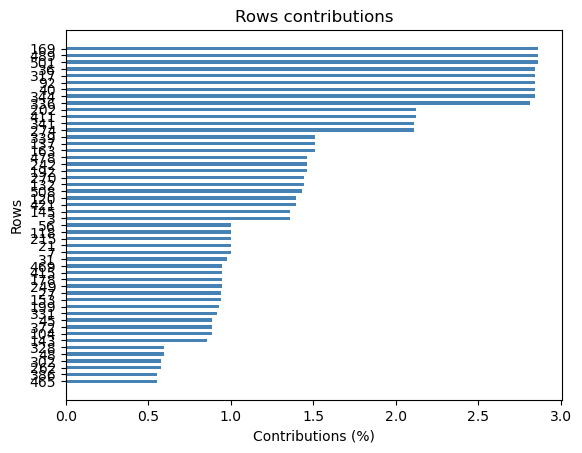

In [112]:
# plot : contributions to the first factor
acp.plot_row_contrib(num_axis=1,nb_values=50)

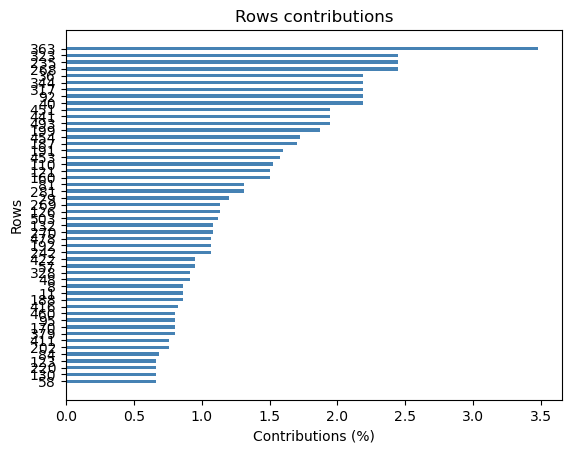

In [113]:
# plot : contributions to the second factor
acp.plot_row_contrib(num_axis=2,nb_values=50)

### Trasition relationship

In [115]:
# Coordinates of individuals from variables - Factor 1
f1 = 1/math.sqrt(acp.eig_[0][0]) * np.dot(Z,acp.col_coord_[:,0])

# print and check coordinates
print(pd.DataFrame(np.transpose(np.array([f1,acp.row_coord_[:,0]])),index=fq_df.index, columns=['transition','actual']))

          transition    actual
Individu                      
83          0.048560  0.048560
151         0.048560  0.048560
177         0.048560  0.048560
184         0.048560  0.048560
198         0.048560  0.048560
...              ...       ...
411         3.325444  3.325444
421        -2.695848 -2.695848
100         1.699506  1.699506
294         0.048560  0.048560
395         1.117012  1.117012

[278 rows x 2 columns]


In [116]:
# Coordinates of variables from individuals - Factor 1
r1 = 1/(n*math.sqrt(acp.eig_[0][0])) * np.dot(np.transpose(Z),acp.row_coord_[:,0])

# print and check correlations
print(pd.DataFrame(np.transpose(np.array([r1,acp.col_coord_[:,0]])),index=fq_df.columns, columns=['transition','actual']))

     transition    actual
FQ1    0.841180  0.841180
FQ2    0.715640  0.715640
FQ3    0.808432  0.808432


# PART 3 MCA

## Data preparation

In [450]:
# Topic 1: MHC columns
mhc_columns = [col for col in df.columns if 'MHC' in col]
df['MHC_Score'] = pd.to_numeric(df[mhc_columns].stack(), errors='coerce').unstack().mean(axis=1)

# Topic 2: NE and PE columns
ne_pe_columns = [col for col in df.columns if 'NE' in col or 'PE' in col]
df['NE_PE_Score'] = pd.to_numeric(df[ne_pe_columns].stack(), errors='coerce').unstack().mean(axis=1)

# Topic 3: Force columns
force_columns = [col for col in df.columns if 'Force' in col]
df['Force_Score'] = pd.to_numeric(df[force_columns].stack(), errors='coerce').unstack().mean(axis=1)

# Topic 4: FQ columns
fq_columns = [col for col in df.columns if 'FQ' in col]
df['FQ_Score'] = pd.to_numeric(df[fq_columns].stack(), errors='coerce').unstack().mean(axis=1)

# Topic 5: Flux columns
flux_columns = [col for col in df.columns if 'Flux' in col]
df['Flux_Score'] = pd.to_numeric(df[flux_columns].stack(), errors='coerce').unstack().mean(axis=1)

# delete columns
columns_to_drop = mhc_columns+ne_pe_columns+force_columns+fq_columns+flux_columns

df_1= df.drop(columns=columns_to_drop)

display(df_1)

GUI               SECTEUR  TAILLE FONCTION   AGE  SEX  \
Individu                                                                    
83        c7251f433fbaa                           2.0           40.0    0   
151       c72c265502d92                           2.0           40.0    0   
177        c7356f5742de                           2.0           40.0    0   
184       c735b612f44b9                           2.0           40.0    0   
198       c7370624543b7                           2.0           40.0    0   
...                 ...                   ...     ...      ...   ...  ...   
411       c788295045c64  Pratiques somatiques     1.0           33.0    0   
421       c791ff32a2577                 sante     1.0           45.0    0   
100        c72625524121                           2.0           40.0    1   
294       c768cf13e0ce7                           2.0           40.0    0   
395       c7838d57eab6c                           1.0           64.0    1   

          SITUFAM  NIVEAUETUDE                FORMATION  \
Individu                                                  
83            3.0          5.0                            
151           3.0          5.0                            
177           3.0          5.0                            
184           3.0          5.0                            
198           3.0          5.0                            
...           ...          ...                      ...   
411           1.0          3.0  Scientifique/artistique   
421           3.0          6.0                  medecin   
100           3.0          3.0                            
294           3.0          3.0                            
395           3.0          1.0                            

         Professional_Flourishing_Status Private_Flourishing_Status     PsurN  \
Individu                                                                        
83                           Flourishing                Flourishing  1.000000   
151                             Moderate                   Moderate  1.071429   
177                             Moderate                   Moderate  1.066667   
184                             Moderate                   Moderate  0.750000   
198                             Moderate                   Moderate  0.866667   
...                                  ...                        ...       ...   
411                             Moderate                   Moderate  1.400000   
421                             Moderate                   Moderate  0.285714   
100                             Moderate                   Moderate  1.500000   
294                             Moderate                   Moderate  1.750000   
395                             Moderate                   Moderate  0.352941   

         Emotional_Flourishing_Status  SITUFAM_binary  
Individu                                               
83                          Depressed               1  
151           Emotionally Languishing               1  
177           Emotionally Languishing               1  
184                         Depressed               1  
198                         Depressed               1  
...                               ...             ...  
411           Emotionally Languishing               0  
421                         Depressed               1  
100           Emotionally Languishing               1  
294           Emotionally Languishing               1  
395                         Depressed               1  

[278 rows x 14 columns]

In [120]:
df_1.columns

Index(['GUI', 'SECTEUR', 'TAILLE', 'FONCTION', 'AGE', 'SEX', 'SITUFAM',
       'NIVEAUETUDE', 'FORMATION', 'Professional_Flourishing_Status',
       'Private_Flourishing_Status', 'PsurN', 'Emotional_Flourishing_Status',
       'MHC_Score', 'NE_PE_Score', 'Force_Score', 'FQ_Score', 'Flux_Score'],
      dtype='object')

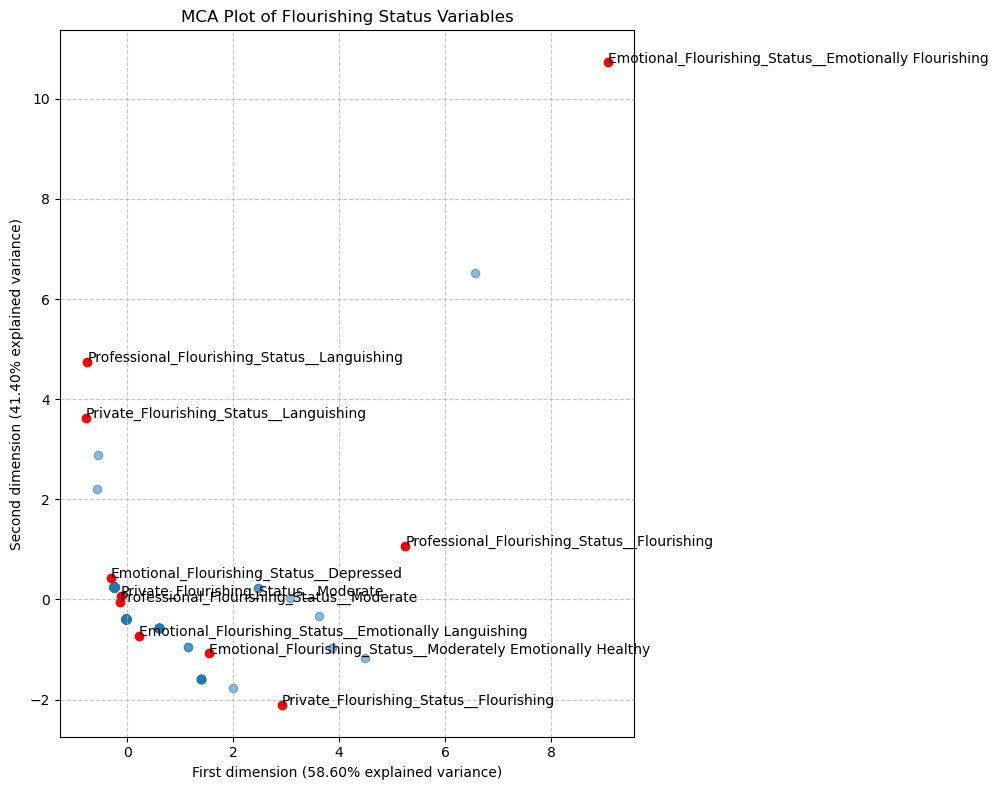

In [452]:
from prince import MCA
import matplotlib.pyplot as plt
import seaborn as sns

mca_columns = ['Professional_Flourishing_Status', 
              'Private_Flourishing_Status', 
              'Emotional_Flourishing_Status']

mca_df = df_1[mca_columns]
mca = MCA(n_components=2, random_state=42)
mca_coords = mca.fit_transform(mca_df)
eigenvalues = mca.eigenvalues_
total_inertia = sum(eigenvalues)
explained_inertia_ratio = [eigenvalue/total_inertia for eigenvalue in eigenvalues]
plt.figure(figsize=(10, 8))
plt.scatter(mca_coords.iloc[:, 0], mca_coords.iloc[:, 1], alpha=0.5)
coordinates = mca.column_coordinates(mca_df)
for index, row in coordinates.iterrows():
    plt.plot(row[0], row[1], 'ro')
    plt.annotate(index, (row[0], row[1]))
plt.title('MCA Plot of Flourishing Status Variables')
plt.xlabel(f'First dimension ({explained_inertia_ratio[0]:.2%} explained variance)')
plt.ylabel(f'Second dimension ({explained_inertia_ratio[1]:.2%} explained variance)')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [454]:
print("\nExplained Inertia Ratio:")
for i, ratio in enumerate(explained_inertia_ratio):
    print(f"Dimension {i+1}: {ratio:.2%}")

print("\nCategory Coordinates:")
print(coordinates)



Explained Inertia Ratio:
Dimension 1: 58.60%
Dimension 2: 41.40%

Category Coordinates:
                                                           0          1
Professional_Flourishing_Status__Flourishing        5.254434   1.061883
Professional_Flourishing_Status__Languishing       -0.750840   4.745744
Professional_Flourishing_Status__Moderate          -0.133445  -0.045107
Private_Flourishing_Status__Flourishing             2.919503  -2.101630
Private_Flourishing_Status__Languishing            -0.778499   3.626987
Private_Flourishing_Status__Moderate               -0.117805   0.073274
Emotional_Flourishing_Status__Depressed            -0.306777   0.428897
Emotional_Flourishing_Status__Emotionally Flour...  9.083727  10.727739
Emotional_Flourishing_Status__Emotionally Langu...  0.216680  -0.733137
Emotional_Flourishing_Status__Moderately Emotio...  1.542256  -1.079444


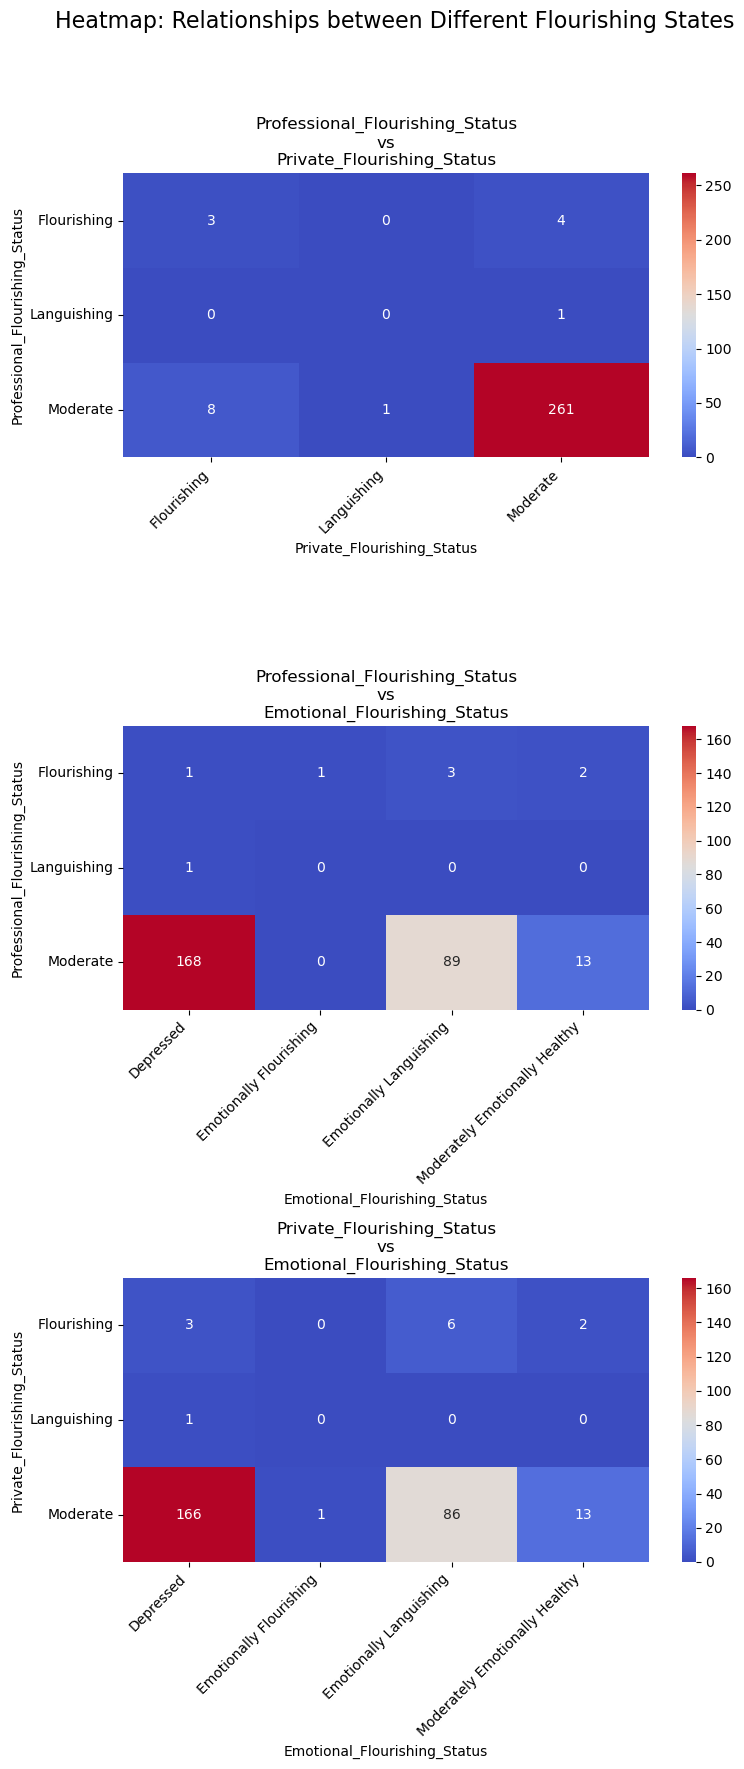

In [458]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

contingency_tables = {}
pairs = [
    ('Professional_Flourishing_Status', 'Private_Flourishing_Status'),
    ('Professional_Flourishing_Status', 'Emotional_Flourishing_Status'), 
    ('Private_Flourishing_Status', 'Emotional_Flourishing_Status')
]

fig, axes = plt.subplots(3, 1, figsize=(8, 18))  # Adjusted for vertical alignment
fig.suptitle('Heatmap: Relationships between Different Flourishing States', fontsize=16)

for idx, (var1, var2) in enumerate(pairs):
    cont_table = pd.crosstab(df_1[var1], df_1[var2])
    
    sns.heatmap(cont_table, annot=True, fmt='d', cmap='coolwarm', ax=axes[idx])  # Changed colormap to 'coolwarm'
    axes[idx].set_title(f'{var1}\nvs\n{var2}')
    
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
    axes[idx].set_yticklabels(axes[idx].get_yticklabels(), rotation=0)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjusted for spacing with title
plt.show()


In [124]:
print("\nFrequency Distribution of States:")
for col in mca_columns:
    print(f"\n{col}:")
    print(df_1[col].value_counts())


Frequency Distribution of States:

Professional_Flourishing_Status:
Professional_Flourishing_Status
Moderate       270
Flourishing      7
Languishing      1
Name: count, dtype: int64

Private_Flourishing_Status:
Private_Flourishing_Status
Moderate       266
Flourishing     11
Languishing      1
Name: count, dtype: int64

Emotional_Flourishing_Status:
Emotional_Flourishing_Status
Depressed                         170
Emotionally Languishing            92
Moderately Emotionally Healthy     15
Emotionally Flourishing             1
Name: count, dtype: int64


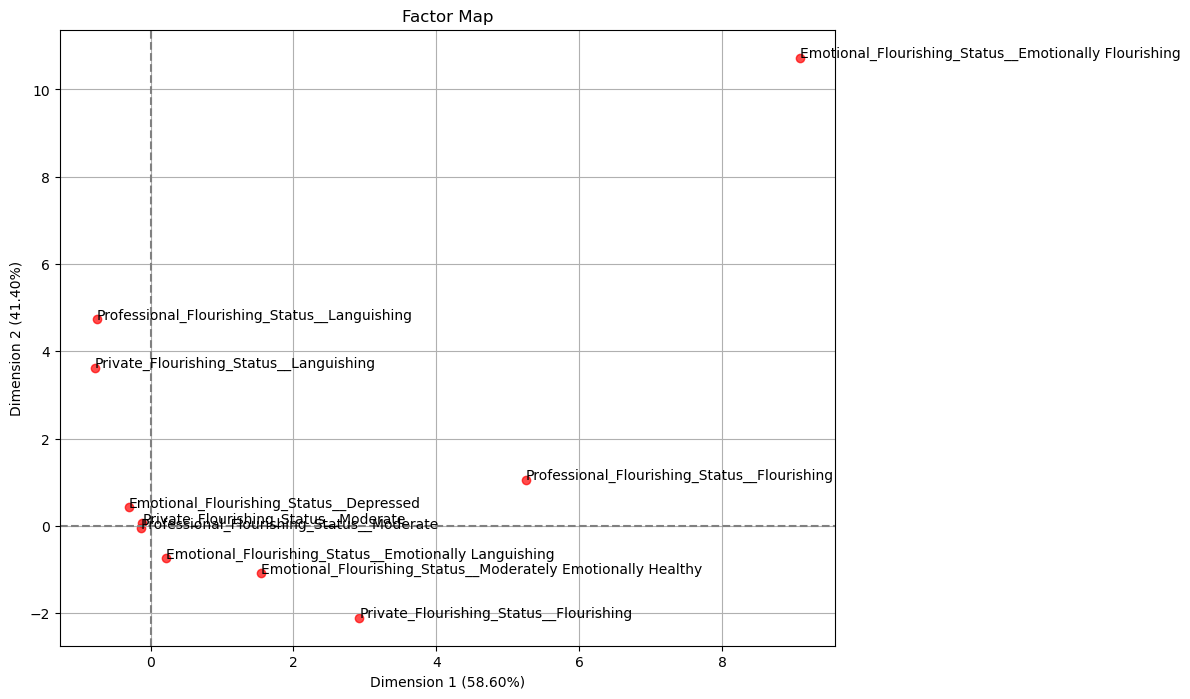

In [125]:
column_coords = mca.column_coordinates(mca_df)

plt.figure(figsize=(10, 8))
plt.scatter(column_coords[0], column_coords[1], alpha=0.7, c='red')
for i, (x, y) in enumerate(zip(column_coords[0], column_coords[1])):
    plt.annotate(column_coords.index[i], (x, y))
plt.axhline(y=0, color='gray', linestyle='--')
plt.axvline(x=0, color='gray', linestyle='--')
plt.title('Factor Map')
plt.xlabel(f'Dimension 1 ({explained_inertia_ratio[0]:.2%})')
plt.ylabel(f'Dimension 2 ({explained_inertia_ratio[1]:.2%})')
plt.grid(True)
plt.show()



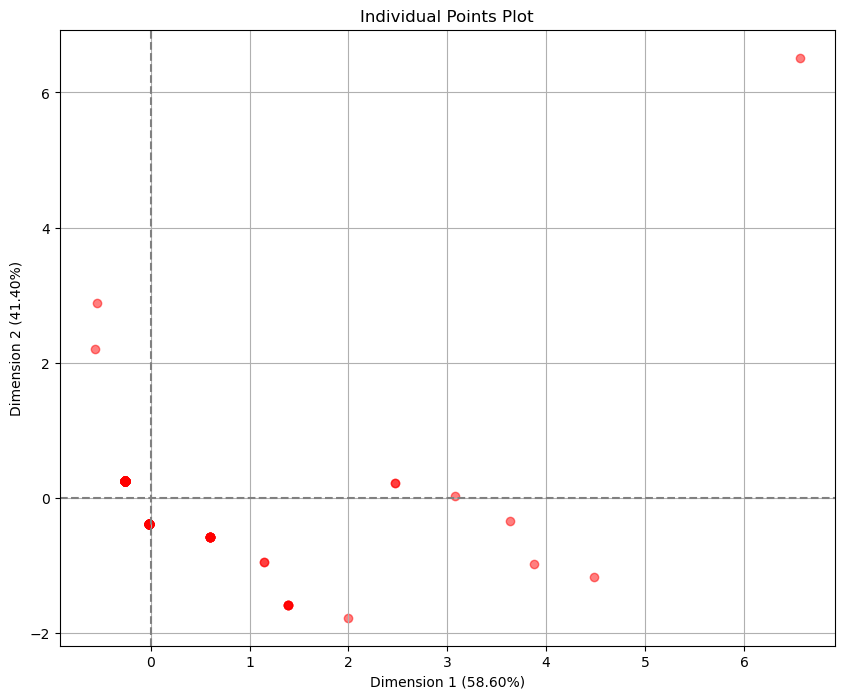

In [126]:
plt.figure(figsize=(10, 8))
plt.scatter(mca_coords.iloc[:, 0], mca_coords.iloc[:, 1], alpha=0.5, c='red')
plt.axhline(y=0, color='gray', linestyle='--')
plt.axvline(x=0, color='gray', linestyle='--')
plt.title('Individual Points Plot')
plt.xlabel(f'Dimension 1 ({explained_inertia_ratio[0]:.2%})')
plt.ylabel(f'Dimension 2 ({explained_inertia_ratio[1]:.2%})')
plt.grid(True)
plt.show()


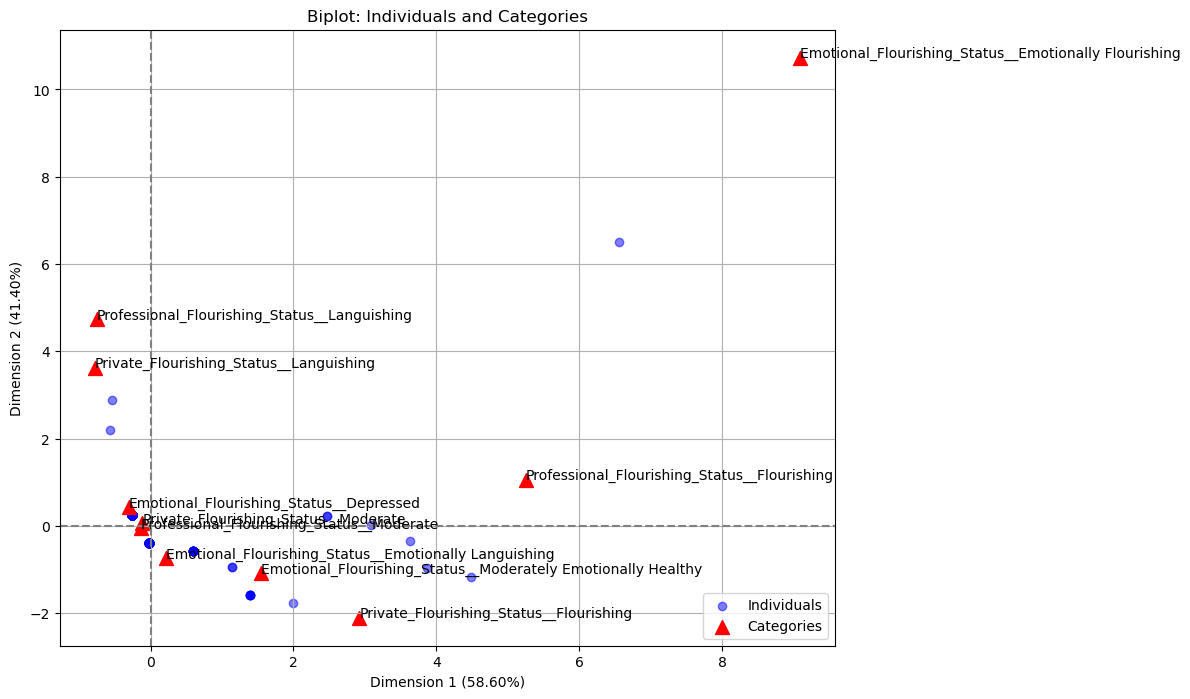

In [127]:
plt.figure(figsize=(10, 8))
plt.scatter(mca_coords.iloc[:, 0], mca_coords.iloc[:, 1], alpha=0.5, color='blue', label='Individuals')
plt.scatter(column_coords[0], column_coords[1], color='red', marker='^', s=100, label='Categories')
for i, (x, y) in enumerate(zip(column_coords[0], column_coords[1])):
    plt.annotate(column_coords.index[i], (x, y))
plt.axhline(y=0, color='gray', linestyle='--')
plt.axvline(x=0, color='gray', linestyle='--')
plt.title('Biplot: Individuals and Categories')
plt.xlabel(f'Dimension 1 ({explained_inertia_ratio[0]:.2%})')
plt.ylabel(f'Dimension 2 ({explained_inertia_ratio[1]:.2%})')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

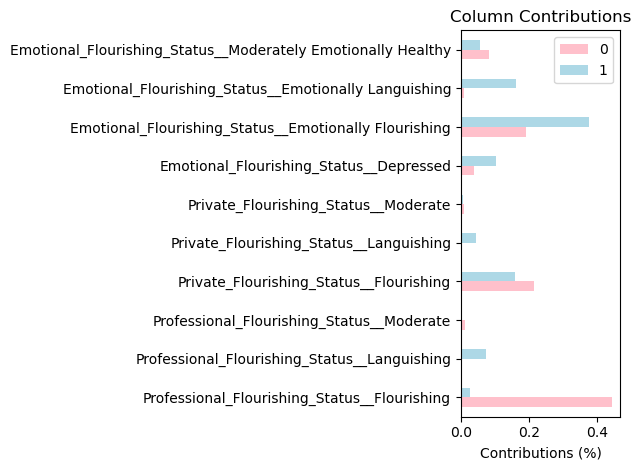

In [128]:
contributions = pd.DataFrame(
    mca.column_contributions_,
    index=column_coords.index
)
plt.figure(figsize=(10, 6))
contributions.plot(kind='barh', color=['pink', 'lightblue'])
plt.title('Column Contributions')
plt.xlabel('Contributions (%)')
plt.tight_layout()
plt.show()


In [129]:
print("\nExplained inertia ratios:")
for i, ratio in enumerate(explained_inertia_ratio):
    print(f"Dimension {i+1}: {ratio:.2%}")


Explained inertia ratios:
Dimension 1: 58.60%
Dimension 2: 41.40%


In [130]:
print("\nFrequency distribution of states:")
for col in mca_columns:
    print(f"\n{col}:")
    print(df_1[col].value_counts())


Frequency distribution of states:

Professional_Flourishing_Status:
Professional_Flourishing_Status
Moderate       270
Flourishing      7
Languishing      1
Name: count, dtype: int64

Private_Flourishing_Status:
Private_Flourishing_Status
Moderate       266
Flourishing     11
Languishing      1
Name: count, dtype: int64

Emotional_Flourishing_Status:
Emotional_Flourishing_Status
Depressed                         170
Emotionally Languishing            92
Moderately Emotionally Healthy     15
Emotionally Flourishing             1
Name: count, dtype: int64


# PART 4 Clustering

## Data preparation

In [133]:
columns_drop = ['MHC_Score','NE_PE_Score','Force_Score','FQ_Score','Flux_Score']
df_2=df.drop(columns=columns_drop)

# select all Force columns
force_columns = [col for col in df_2.columns if 'Force' in col]

# calculate Force mean
df_2['Force_Score'] = df_2[force_columns].mean(axis=1)

# select all Flux columns
flux_columns = [col for col in df_2.columns if 'Flux' in col]

# calculate Flux mean
df_2['Flux_Score'] = df_2[flux_columns].mean(axis=1)

# select all FQ columns
fq_columns = [col for col in df_2.columns if 'FQ' in col]

# calculate FQ mean
df_2['FQ_Score'] = df_2[fq_columns].mean(axis=1)

display(df_2)

GUI               SECTEUR  TAILLE FONCTION  ANCIENNETE  \
Individu                                                                     
83        c7251f433fbaa                           2.0                  5.0   
151       c72c265502d92                           2.0                  5.0   
177        c7356f5742de                           2.0                  5.0   
184       c735b612f44b9                           2.0                  5.0   
198       c7370624543b7                           2.0                  5.0   
...                 ...                   ...     ...      ...         ...   
411       c788295045c64  Pratiques somatiques     1.0                  4.0   
421       c791ff32a2577                 sante     1.0                  9.0   
100        c72625524121                           2.0                  1.0   
294       c768cf13e0ce7                           2.0                  1.0   
395       c7838d57eab6c                           1.0                 21.0   

           AGE  SEX  SITUFAM  NIVEAUETUDE                FORMATION  ...  \
Individu                                                            ...   
83        40.0    0      3.0          5.0                           ...   
151       40.0    0      3.0          5.0                           ...   
177       40.0    0      3.0          5.0                           ...   
184       40.0    0      3.0          5.0                           ...   
198       40.0    0      3.0          5.0                           ...   
...        ...  ...      ...          ...                      ...  ...   
411       33.0    0      1.0          3.0  Scientifique/artistique  ...   
421       45.0    0      3.0          6.0                  medecin  ...   
100       40.0    1      3.0          3.0                           ...   
294       40.0    0      3.0          3.0                           ...   
395       64.0    1      3.0          1.0                           ...   

          Flux7  Flux8  Flux9  Professional_Flourishing_Status  \
Individu                                                         
83          4.0    5.0    4.0                      Flourishing   
151         4.0    5.0    4.0                         Moderate   
177         4.0    5.0    4.0                         Moderate   
184         4.0    5.0    4.0                         Moderate   
198         4.0    5.0    4.0                         Moderate   
...         ...    ...    ...                              ...   
411         5.0    6.0    5.0                         Moderate   
421         4.0    4.0    3.0                         Moderate   
100         4.0    3.0    5.0                         Moderate   
294         6.0    6.0    6.0                         Moderate   
395         5.0    6.0    6.0                         Moderate   

          Private_Flourishing_Status     PsurN  Emotional_Flourishing_Status  \
Individu                                                                       
83                       Flourishing  1.000000                     Depressed   
151                         Moderate  1.071429       Emotionally Languishing   
177                         Moderate  1.066667       Emotionally Languishing   
184                         Moderate  0.750000                     Depressed   
198                         Moderate  0.866667                     Depressed   
...                              ...       ...                           ...   
411                         Moderate  1.400000       Emotionally Languishing   
421                         Moderate  0.285714                     Depressed   
100                         Moderate  1.500000       Emotionally Languishing   
294                         Moderate  1.750000       Emotionally Languishing   
395                         Moderate  0.352941                     Depressed   

          Force_Score  Flux_Score  FQ_Score  
Individu                                     
83           4.166667    4.222222  3.

## Clustering 1

### Hierarchy clustering

In [136]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [137]:
# select clustering variables
clustering_features = df_2[[
    'Force_Score', 
    'Flux_Score', 
    'FQ_Score'
]]

In [138]:
# delete NAN
clustering_features = clustering_features.dropna()

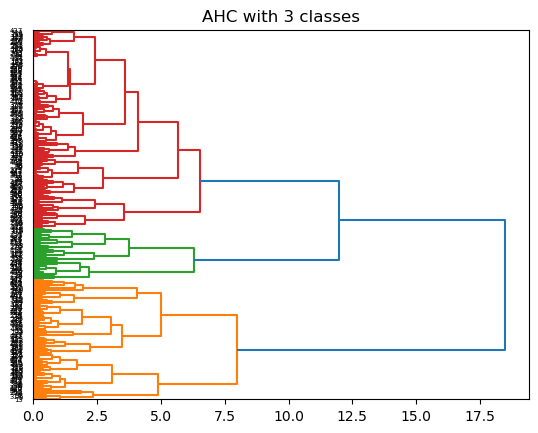

In [139]:
# 计算距离矩阵，使用 'ward' 方法
Z = linkage(clustering_features, method='ward')

# show classes : cut at distance t=10
plt.title('AHC with 3 classes')
dendrogram(Z,labels=clustering_features.index,orientation='right',color_threshold=10)
plt.show()

In [140]:
# cutting at t = 8 ==> 3 classes retained
groupes_cah = fcluster(Z,t=10,criterion='distance')
print(groupes_cah)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 1 3 3 2 3 3 3 3 3 3 1 3 3 3 3 1
 2 1 2 3 3 3 3 2 3 1 3 3 2 2 1 2 3 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1
 1 3 3 2 1 3 3 2 1 1 3 3 3 2 3 3 2 2 3 1 1 2 3 3 3 1 3 3 3 3 1 1 2 1 3 1 2
 1 3 3 1 1 1 2 1 3 2 1 1 1 2 1 3 3 2 1 3 1 1 1 2 3 3 3 3 3 3 3 3 3 1 3 3 3
 3 3 3 1 3 1 3 3 1 2 3 3 1 1 1 1 1 3 2 1 2 1 3 1 1 1 3 1 1 2 3 2 3 3 2 3 3
 3 2 1 2 1 1 2 3 3 3 2 1 1 1 1 1 3 3 3 1 3 3 2 1 3 1 3 1 1 3 1 3 3 3 1 3 2
 2 1 3 3 1 2 3 3 1 1 3 3 3 1 1 1 1 3 1 1 1 1 3 1 1 3 3 3 3 3 1 1 3 3 3 1 2
 3 3 1 1 3 1 3 2 3 1 3 3 1 2 2 1 3 3 3]


In [141]:
# select indices per groups
idg = np.argsort(groupes_cah)

# plrint observations and their corresponding group
print(pd.DataFrame(clustering_features.index[idg],groupes_cah[idg]))

    Individu
1        513
1        331
1         59
1        480
1        353
..       ...
3        105
3        466
3        224
3        343
3        395

[278 rows x 1 columns]


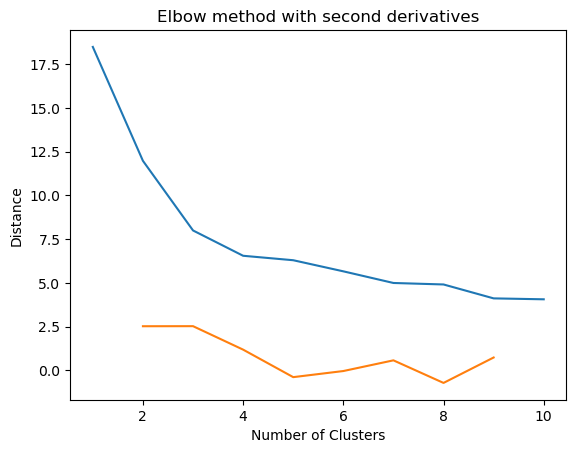

In [142]:
# Compute the linkage matrix
Z = linkage(clustering_features,method='ward',metric='euclidean')

# Determine the optimal number of clusters using the elbow method
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.xlabel("Number of Clusters")
plt.ylabel("Distance")
plt.title("Elbow method with second derivatives")
plt.show()

In [143]:
# The elbow point represents the optimal number of clusters
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("The optimal number of clusters is:", k)

The optimal number of clusters is: 3


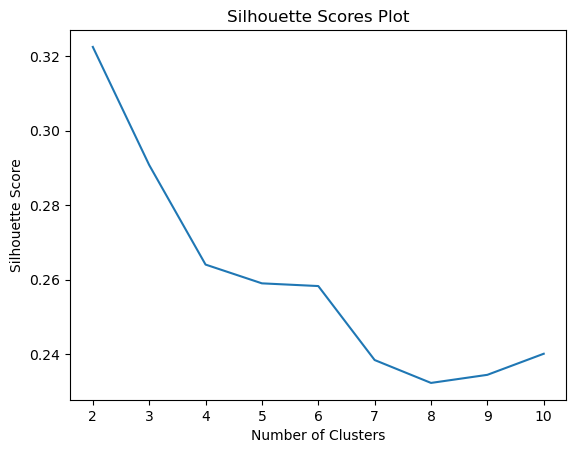

In [144]:
# Create a list to store the silhouette scores
silhouette_scores = []

# Loop over a range of possible number of clusters
for n_clusters in range(2, 11):
    # Create an instance of AgglomerativeClustering
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    
    # Fit the clusterer to the data
    clusterer.fit(clustering_features)
    
    # Predict the cluster labels for each data point
    cluster_labels = clusterer.labels_
    
    # Compute the silhouette score for the current number of clusters
    score = silhouette_score(clustering_features, cluster_labels)
    
    # Add the score to the list of silhouette scores
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores Plot")
plt.show()

In [145]:
# The optimal number of clusters is the value that corresponds to the highest silhouette score
best_n_clusters = np.argmax(silhouette_scores) + 2
print("The best number of clusters is:", best_n_clusters)

The best number of clusters is: 2


### k-means

In [147]:
# k-means on the standardized data
from sklearn import cluster
kmeans = cluster.KMeans(n_clusters=3)
kmeans.fit(clustering_features)

C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans(n_clusters=3)

In [148]:
# print inertia
print(kmeans.inertia_)

# aggregate indices by group
idk = np.argsort(kmeans.labels_)

231.32441019556904


In [149]:
# print instances et their groups
print(pd.DataFrame(df_2.index[idk],kmeans.labels_[idk]))

    Individu
0        242
0        227
0        125
0         53
0        145
..       ...
2        466
2        224
2        451
2        453
2        395

[278 rows x 1 columns]


In [150]:
# distances to the center of the observations classes
print(kmeans.transform(clustering_features))

[[1.40578334 1.46374115 0.13268137]
 [1.40578334 1.46374115 0.13268137]
 [1.40578334 1.46374115 0.13268137]
 [1.40578334 1.46374115 0.13268137]
 [1.40578334 1.46374115 0.13268137]
 [1.40578334 1.46374115 0.13268137]
 [1.40578334 1.46374115 0.13268137]
 [1.40578334 1.46374115 0.13268137]
 [1.40578334 1.46374115 0.13268137]
 [1.40578334 1.46374115 0.13268137]
 [1.40578334 1.46374115 0.13268137]
 [1.40578334 1.46374115 0.13268137]
 [1.40578334 1.46374115 0.13268137]
 [1.40578334 1.46374115 0.13268137]
 [1.40578334 1.46374115 0.13268137]
 [1.40578334 1.46374115 0.13268137]
 [1.40578334 1.46374115 0.13268137]
 [1.40578334 1.46374115 0.13268137]
 [1.47938521 2.42583522 1.10135414]
 [1.37881005 1.52300885 0.11274134]
 [2.05342181 1.05128273 1.15978955]
 [1.36019495 2.13019162 0.77049788]
 [2.18392724 1.07421484 1.32577413]
 [1.37881005 1.52300885 0.11274134]
 [2.87131342 0.18745527 1.507965  ]
 [1.40578334 1.46374115 0.13268137]
 [1.3564278  1.58444396 0.14732876]
 [1.17545956 2.06891819 1.12

In [151]:
# check correspondance with AHC groups
pd.crosstab(groupes_cah,kmeans.labels_)

col_0   0   1    2
row_0             
1      70   0   21
2       0  37    1
3       6  16  127

In [152]:
# package to estimate partitions
from sklearn import metrics

# sihouette score metrics
# make number of clusters vary from 0 to 10
res = np.arange(9,dtype="double")
for k in np.arange(9):
    km = cluster.KMeans(n_clusters=k+2)
    km.fit(clustering_features)
    res[k] = metrics.silhouette_score(clustering_features,km.labels_)
    
print(res)

C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known

[0.31775897 0.31533003 0.2752676  0.29047274 0.29756869 0.29279175
 0.26095692 0.26911096 0.27191078]


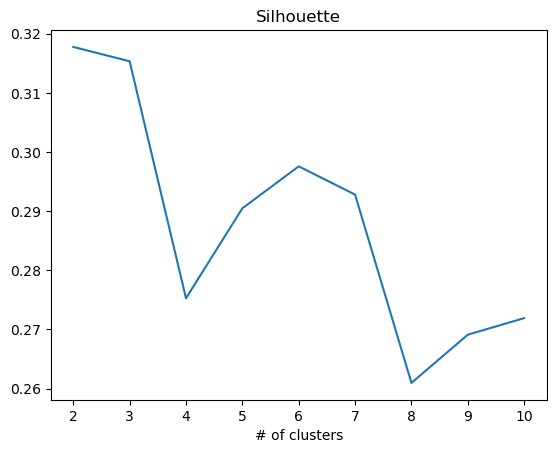

In [153]:
# plot
import matplotlib.pyplot as plt
plt.title("Silhouette")
plt.xlabel("# of clusters")
plt.plot(np.arange(2,11,1),res)
plt.show()

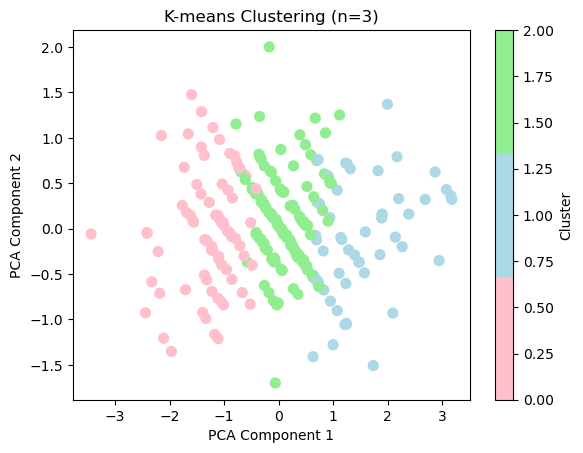

In [154]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


pca = PCA(n_components=2)
pca_data = pca.fit_transform(clustering_features)

custom_cmap = ListedColormap(['pink', 'lightblue', 'lightgreen'])


plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.labels_, cmap=custom_cmap, s=50)
plt.title("K-means Clustering (n=3)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


## Interpretation

In [156]:
# creat cluster_label
clustering_features['Cluster_Label'] = groupes_cah

In [157]:
# compute the mean of each group
group_summary = clustering_features.groupby('Cluster_Label').mean()

group_summary

Force_Score  Flux_Score  FQ_Score
Cluster_Label                                   
1                 3.582418    3.351648  3.007326
2                 5.243421    5.122807  4.578947
3                 4.289709    4.211037  3.787472

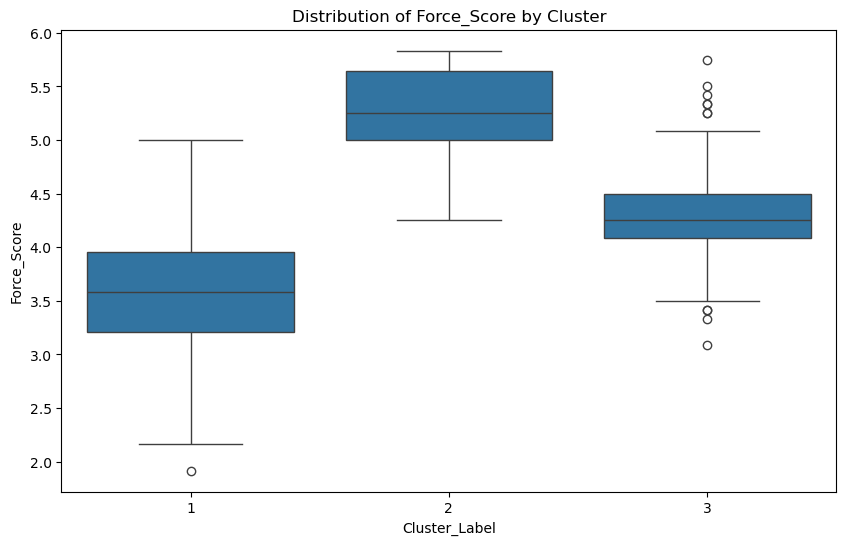

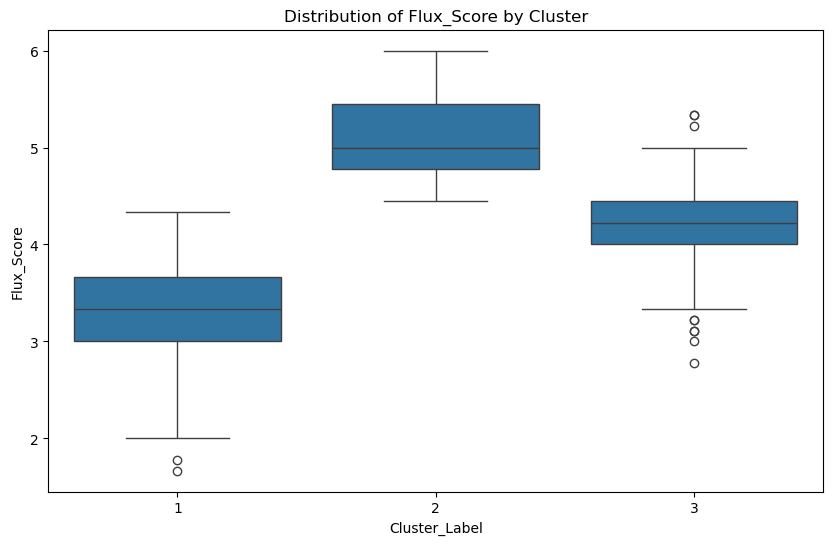

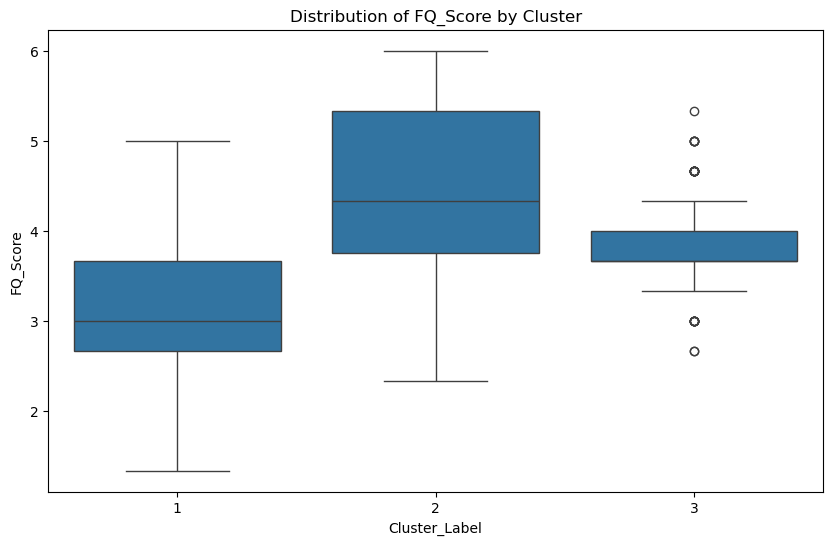

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt

# 可视化每个特征在群组中的分布
for feature in ['Force_Score', 'Flux_Score', 'FQ_Score']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster_Label', y=feature, data=clustering_features)
    plt.title(f"Distribution of {feature} by Cluster")
    plt.show()

## Preprare data for clustering 2

In [160]:
# force
force_columns =[col for col in df_2.columns if 'Force' in col] 
# Create a new DataFrame with only the force-related columns
force_df = df_2[force_columns].drop(columns = ['Force_Score'])

# fcq
fq_columns =[col for col in df_2.columns if 'FQ' in col] 
# Create a new DataFrame with only the fq related columns
fq_df = df_2[fq_columns].drop(columns = ['FQ_Score'])

#flux
flux_columns =[col for col in df_2.columns if 'Flux' in col] 
# Create a new DataFrame with only the flux related columns
flux_df = df_2[flux_columns].drop(columns = ['Flux_Score'])

display(flux_df)

display(force_df)

display(fq_df)

Flux1  Flux2  Flux3  Flux4  Flux5  Flux6  Flux7  Flux8  Flux9
Individu                                                               
83          3.0    4.0    5.0    5.0    4.0    4.0    4.0    5.0    4.0
151         3.0    4.0    5.0    5.0    4.0    4.0    4.0    5.0    4.0
177         3.0    4.0    5.0    5.0    4.0    4.0    4.0    5.0    4.0
184         3.0    4.0    5.0    5.0    4.0    4.0    4.0    5.0    4.0
198         3.0    4.0    5.0    5.0    4.0    4.0    4.0    5.0    4.0
...         ...    ...    ...    ...    ...    ...    ...    ...    ...
411         5.0    5.0    5.0    6.0    6.0    6.0    5.0    6.0    5.0
421         2.0    5.0    5.0    5.0    5.0    4.0    4.0    4.0    3.0
100         3.0    5.0    5.0    6.0    6.0    3.0    4.0    3.0    5.0
294         1.0    6.0    6.0    6.0    6.0    4.0    6.0    6.0    6.0
395         4.0    5.0    6.0    6.0    6.0    4.0    5.0    6.0    6.0

[278 rows x 9 columns]

Force1  Force4  Force6  Force8  Force12  Force13  Force17  Force18  \
Individu                                                                       
83           4.0     4.0     5.0     4.0      4.0      4.0      5.0      4.0   
151          4.0     4.0     5.0     4.0      4.0      4.0      5.0      4.0   
177          4.0     4.0     5.0     4.0      4.0      4.0      5.0      4.0   
184          4.0     4.0     5.0     4.0      4.0      4.0      5.0      4.0   
198          4.0     4.0     5.0     4.0      4.0      4.0      5.0      4.0   
...          ...     ...     ...     ...      ...      ...      ...      ...   
411          6.0     6.0     6.0     6.0      3.0      6.0      5.0      4.0   
421          3.0     4.0     5.0     5.0      2.0      4.0      5.0      3.0   
100          5.0     5.0     5.0     3.0      3.0      5.0      3.0      4.0   
294          6.0     2.0     6.0     6.0      4.0      5.0      4.0      5.0   
395          3.0     4.0     5.0     5.0      5.0      4.0      2.0      3.0   

          Force19  Force22  Force23  Force24  
Individu                                      
83            4.0      4.0      5.0      3.0  
151           4.0      4.0      5.0      3.0  
177           4.0      4.0      5.0      3.0  
184           4.0      4.0      5.0      3.0  
198           4.0      4.0      5.0      3.0  
...           ...      ...      ...      ...  
411           6.0      6.0      4.0      6.0  
421           4.0      4.0      6.0      4.0  
100           4.0      4.0      6.0      4.0  
294           4.0      4.0      4.0      2.0  
395           4.0      3.0      2.0      4.0  

[278 rows x 12 columns]

FQ1  FQ2  FQ3
Individu               
83        4.0  2.0  5.0
151       4.0  2.0  5.0
177       4.0  2.0  5.0
184       4.0  2.0  5.0
198       4.0  2.0  5.0
...       ...  ...  ...
411       6.0  5.0  6.0
421       3.0  1.0  2.0
100       5.0  3.0  6.0
294       4.0  2.0  5.0
395       4.0  3.0  6.0

[278 rows x 3 columns]

In [161]:
# import the usual modules
# to manage directories
import os
# to handle matrix computations
import numpy as np
# to handle tabular data
import pandas as pd
# to handle plots and graphs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# if fanalysis is already installed, import it - else install and import it
try:
    from fanalysis.pca import PCA
except:
    !pip install fanalysis
    from fanalysis.pca import PCA

In [162]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# standardize PCA
def perform_pca(data, n_components, prefix):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data_scaled)
    return pd.DataFrame(principal_components, columns=[f"{prefix}_Factor_{i+1}" for i in range(n_components)])


force_factors = perform_pca(force_df, n_components=2, prefix="Force")
flux_factors = perform_pca(flux_df, n_components=2, prefix="Flux")
fq_factors = perform_pca(fq_df, n_components=2, prefix="FQ")

# combine factors
all_factors = pd.concat([force_factors, flux_factors, fq_factors], axis=1)


print("Force Factors:")
display(force_factors)
print("Flux Factors:")
display(flux_factors)
print("FQ Factors:")
display(fq_factors)

print("Combined Factors for Clustering:")
display(all_factors)

# use all_factors to cluster

Force Factors:


Force_Factor_1  Force_Factor_2
0         -0.077168        0.056030
1         -0.077168        0.056030
2         -0.077168        0.056030
3         -0.077168        0.056030
4         -0.077168        0.056030
..              ...             ...
273        3.118283       -1.106347
274       -0.487742       -0.523262
275        0.067389       -1.646983
276        0.404091        0.304835
277       -1.334976       -0.063926

[278 rows x 2 columns]

Flux Factors:


Flux_Factor_1  Flux_Factor_2
0         0.432349       0.393149
1         0.432349       0.393149
2         0.432349       0.393149
3         0.432349       0.393149
4         0.432349       0.393149
..             ...            ...
273       2.930436       1.293413
274      -0.029322       0.966685
275       0.548347       1.082250
276       3.343596       0.505634
277       3.136148       0.544531

[278 rows x 2 columns]

FQ Factors:


FQ_Factor_1  FQ_Factor_2
0       0.048560    -0.397135
1       0.048560    -0.397135
2       0.048560    -0.397135
3       0.048560    -0.397135
4       0.048560    -0.397135
..           ...          ...
273     3.325444     1.196982
274    -2.695848     0.351784
275     1.699506    -0.243819
276     0.048560    -0.397135
277     1.117012    -0.011886

[278 rows x 2 columns]

Combined Factors for Clustering:


Force_Factor_1  Force_Factor_2  Flux_Factor_1  Flux_Factor_2  \
0         -0.077168        0.056030       0.432349       0.393149   
1         -0.077168        0.056030       0.432349       0.393149   
2         -0.077168        0.056030       0.432349       0.393149   
3         -0.077168        0.056030       0.432349       0.393149   
4         -0.077168        0.056030       0.432349       0.393149   
..              ...             ...            ...            ...   
273        3.118283       -1.106347       2.930436       1.293413   
274       -0.487742       -0.523262      -0.029322       0.966685   
275        0.067389       -1.646983       0.548347       1.082250   
276        0.404091        0.304835       3.343596       0.505634   
277       -1.334976       -0.063926       3.136148       0.544531   

     FQ_Factor_1  FQ_Factor_2  
0       0.048560    -0.397135  
1       0.048560    -0.397135  
2       0.048560    -0.397135  
3       0.048560    -0.397135  
4       0.048560    -0.397135  
..           ...          ...  
273     3.325444     1.196982  
274    -2.695848     0.351784  
275     1.699506    -0.243819  
276     0.048560    -0.397135  
277     1.117012    -0.011886  

[278 rows x 6 columns]

## Clustering 2

### Hierarchy clustering

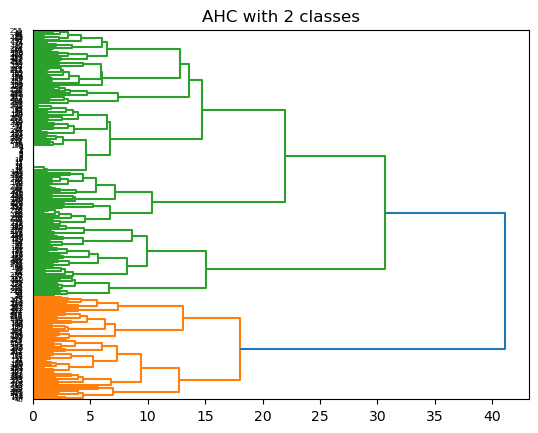

In [165]:
# delete NAN
all_factors = all_factors.dropna()

# 计算距离矩阵，使用 'ward' 方法
Z = linkage(all_factors, method='ward')

# show classes : cut at distance t=35
plt.title('AHC with 2 classes')
dendrogram(Z,labels = all_factors.index,orientation='right',color_threshold=35)
plt.show()

In [166]:
# cutting at t = 8 ==> 3 classes retained
groupes_cah = fcluster(Z,t=35,criterion='distance')
print(groupes_cah)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 1
 1 1 2 2 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 1 1 1 1 2 1 2 2 1 2 1 2
 1 2 2 1 1 1 2 1 2 2 2 1 2 2 1 2 2 2 1 2 1 1 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2
 2 2 2 1 2 1 2 2 2 2 2 2 1 1 1 1 1 2 2 1 2 2 2 2 1 1 2 1 1 2 2 2 2 2 2 2 2
 2 2 1 2 1 1 2 2 2 2 2 1 1 1 2 1 2 2 2 1 2 2 2 1 2 1 2 1 2 2 1 2 2 2 2 2 2
 2 1 2 2 1 2 2 2 2 1 2 2 2 1 1 1 2 2 1 1 1 2 2 1 1 2 2 2 2 1 2 2 2 2 2 2 2
 2 2 1 1 1 1 1 2 2 1 2 2 1 2 2 1 2 2 2]


In [167]:
# select indices per groups
idg = np.argsort(groupes_cah)

# plrint observations and their corresponding group
print(pd.DataFrame(all_factors.index[idg],groupes_cah[idg]))

      0
1   210
1    71
1    70
1   187
1   215
..  ...
2   106
2   108
2   110
2    66
2   277

[278 rows x 1 columns]


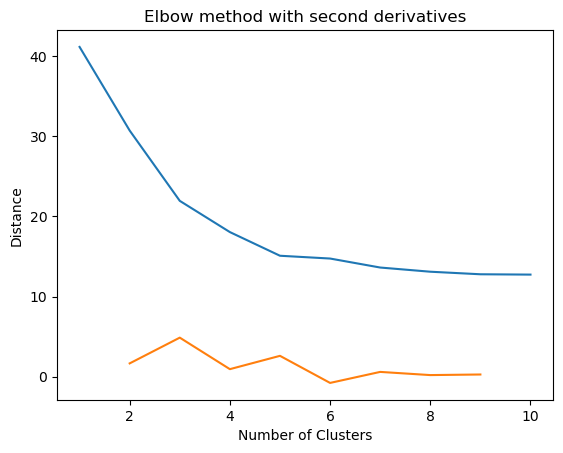

In [168]:
# Compute the linkage matrix
Z = linkage(all_factors,method='ward',metric='euclidean')

# Determine the optimal number of clusters using the elbow method
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.xlabel("Number of Clusters")
plt.ylabel("Distance")
plt.title("Elbow method with second derivatives")
plt.show()

In [169]:
# The elbow point represents the optimal number of clusters
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("The optimal number of clusters is:", k)

The optimal number of clusters is: 3


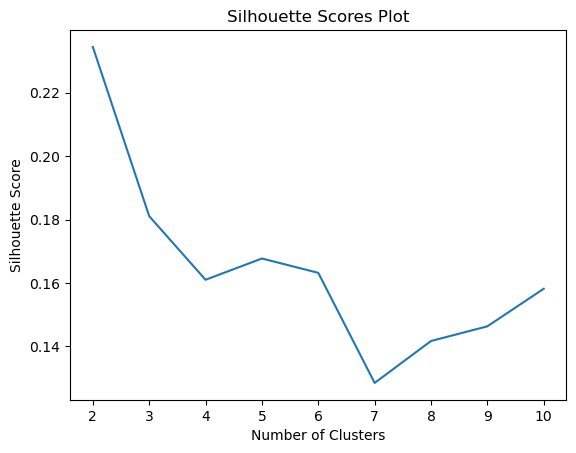

In [170]:
# Create a list to store the silhouette scores
silhouette_scores = []

# Loop over a range of possible number of clusters
for n_clusters in range(2, 11):
    # Create an instance of AgglomerativeClustering
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    
    # Fit the clusterer to the data
    clusterer.fit(all_factors)
    
    # Predict the cluster labels for each data point
    cluster_labels = clusterer.labels_
    
    # Compute the silhouette score for the current number of clusters
    score = silhouette_score(all_factors, cluster_labels)
    
    # Add the score to the list of silhouette scores
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores Plot")
plt.show()

In [171]:
# The optimal number of clusters is the value that corresponds to the highest silhouette score
best_n_clusters = np.argmax(silhouette_scores) + 2
print("The best number of clusters is:", best_n_clusters)

The best number of clusters is: 2


### k means

In [173]:
# k-means on the standardized data
from sklearn import cluster
kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(all_factors)

C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans(n_clusters=2)

In [174]:
# print inertia
print(kmeans.inertia_)

# aggregate indices by group
idk = np.argsort(kmeans.labels_)

2565.0646738084406


In [175]:
# print instances et their groups
print(pd.DataFrame(df_2.index[idk],kmeans.labels_[idk]))

    Individu
0         83
0        309
0        254
0        436
0        423
..       ...
1        355
1        289
1        181
1        384
1        503

[278 rows x 1 columns]


In [176]:
# distances to the center of the observations classes
print(kmeans.transform(all_factors))

[[1.56440017 2.60405879]
 [1.56440017 2.60405879]
 [1.56440017 2.60405879]
 [1.56440017 2.60405879]
 [1.56440017 2.60405879]
 [1.56440017 2.60405879]
 [1.56440017 2.60405879]
 [1.56440017 2.60405879]
 [1.56440017 2.60405879]
 [1.56440017 2.60405879]
 [1.56440017 2.60405879]
 [1.56440017 2.60405879]
 [1.56440017 2.60405879]
 [1.56440017 2.60405879]
 [1.56440017 2.60405879]
 [1.56440017 2.60405879]
 [1.56440017 2.60405879]
 [1.56440017 2.60405879]
 [4.48463363 3.05121039]
 [2.43665809 3.10674857]
 [2.12630366 4.84009048]
 [4.03777309 2.94294097]
 [2.50288783 5.22148895]
 [2.87714662 3.37009562]
 [2.14423962 5.86586223]
 [2.50532165 3.40392015]
 [2.05847226 2.44249587]
 [3.8710239  2.63816418]
 [2.30599974 3.19417267]
 [2.20835978 5.07596606]
 [2.74800916 3.28833533]
 [4.45464531 2.61761478]
 [3.01187969 3.97788916]
 [5.08112805 3.56512123]
 [3.8600702  5.63338328]
 [2.65919361 4.31432571]
 [5.45506299 3.26206934]
 [3.32053273 6.44060011]
 [4.72757498 2.80165904]
 [3.59750838 7.37807281]


In [177]:
# check correspondance with AHC groups
pd.crosstab(groupes_cah,kmeans.labels_)

col_0    0   1
row_0         
1        3  75
2      156  44

In [178]:
# package to estimate partitions
from sklearn import metrics

# sihouette score metrics
# make number of clusters vary from 0 to 10
res = np.arange(9,dtype="double")
for k in np.arange(9):
    km = cluster.KMeans(n_clusters=k+2)
    km.fit(all_factors)
    res[k] = metrics.silhouette_score(all_factors,km.labels_)
    
print(res)

C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known

[0.24371483 0.19928584 0.16778066 0.19424814 0.16699067 0.17796296
 0.14773319 0.18205909 0.18585146]


C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


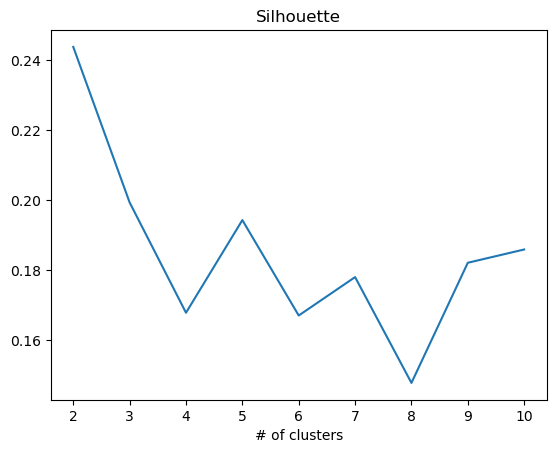

In [179]:
# plot
import matplotlib.pyplot as plt
plt.title("Silhouette")
plt.xlabel("# of clusters")
plt.plot(np.arange(2,11,1),res)
plt.show()

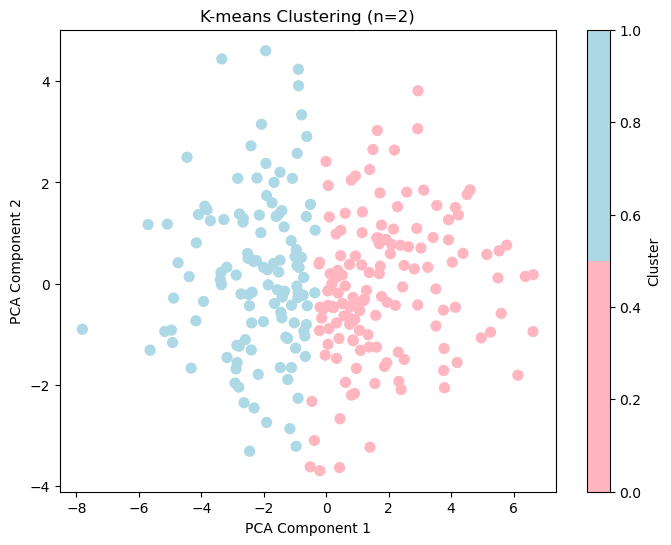

In [180]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 对标准化数据降维
pca = PCA(n_components=2)
pca_data = pca.fit_transform(all_factors)


custom_cmap = ListedColormap(['lightpink', 'lightblue'])


plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.labels_, cmap=custom_cmap, s=50)
plt.title("K-means Clustering (n=2)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


## interpretation 2

In [182]:
# creat cluster_label
all_factors['Cluster_Label'] = groupes_cah

# compute the mean of each group
group_summary = all_factors.groupby('Cluster_Label').mean()

group_summary

Force_Factor_1  Force_Factor_2  Flux_Factor_1  Flux_Factor_2  \
Cluster_Label                                                                 
1                   -1.397851        0.306317      -2.016409      -0.380274   
2                    0.545162       -0.119464       0.786400       0.148307   

               FQ_Factor_1  FQ_Factor_2  
Cluster_Label                            
1                -1.226801     0.197343  
2                 0.478452    -0.076964

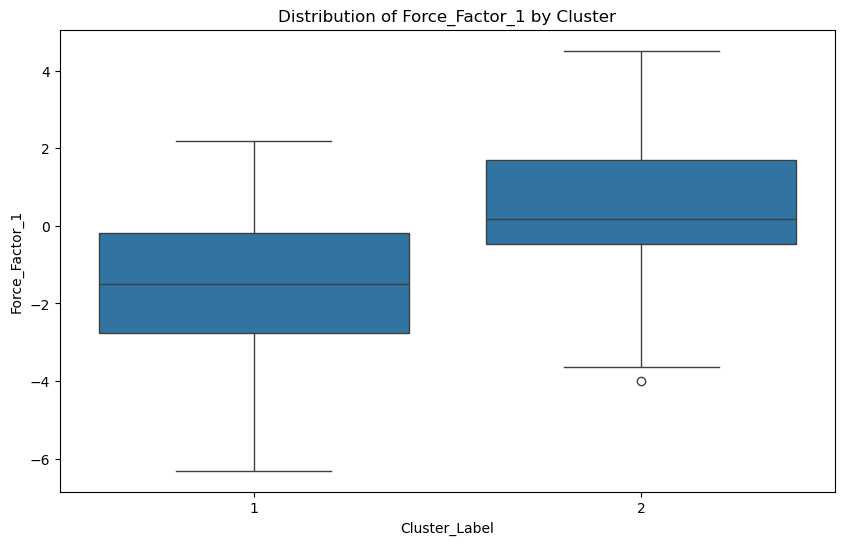

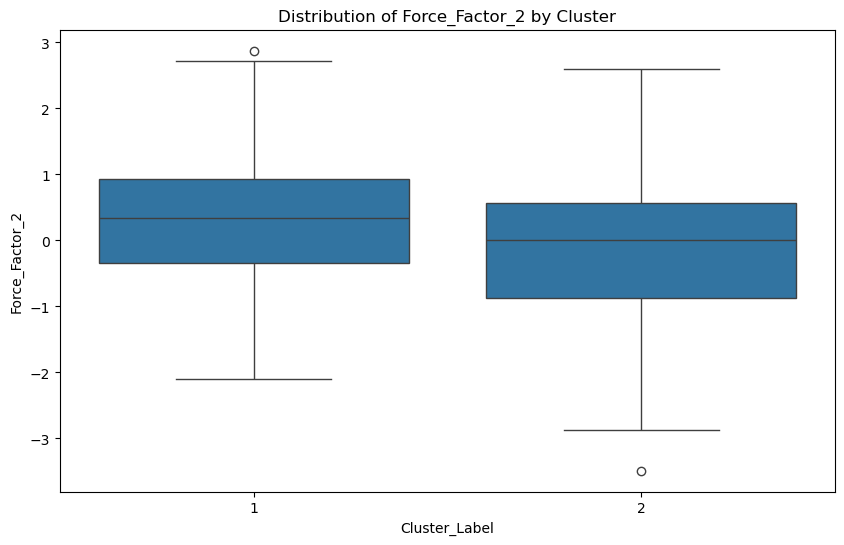

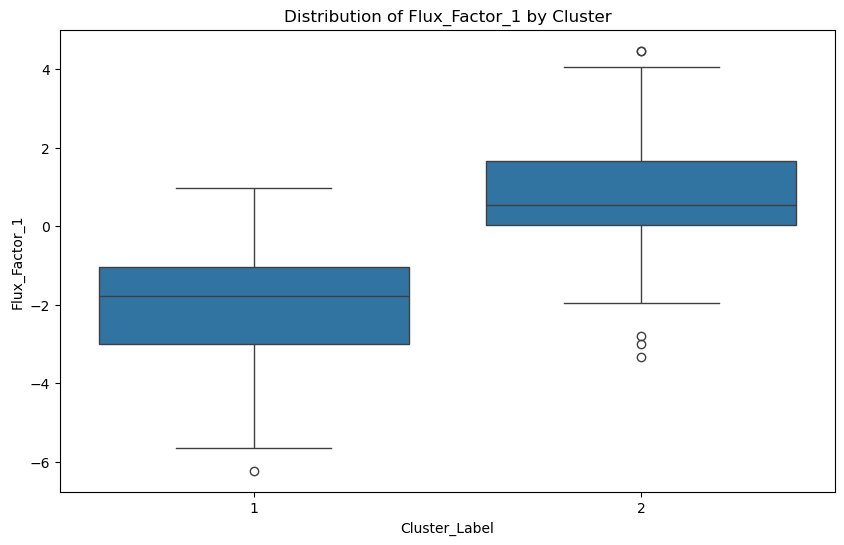

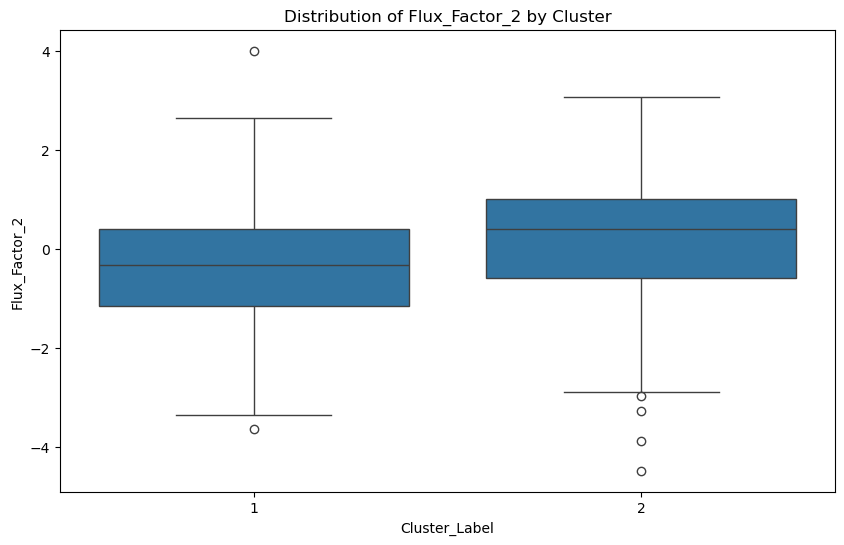

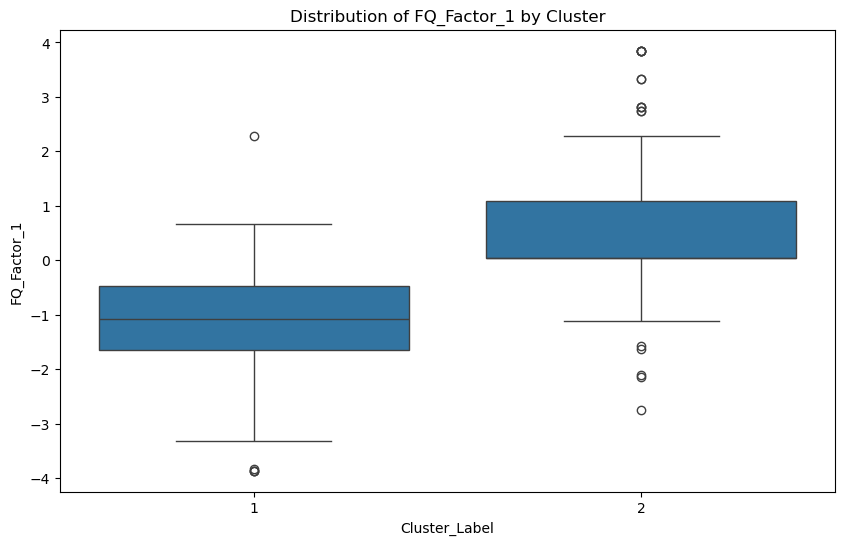

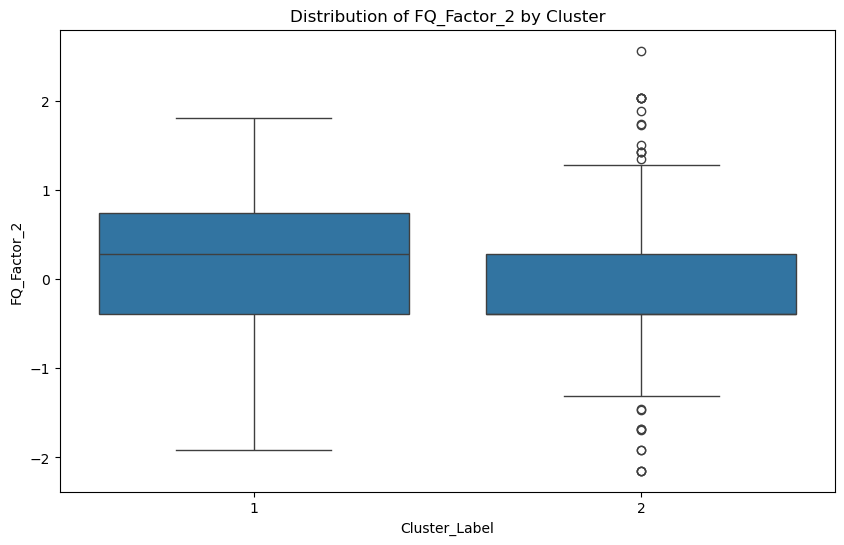

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt

# 可视化每个特征在群组中的分布
for feature in ['Force_Factor_1','Force_Factor_2','Flux_Factor_1', 'Flux_Factor_2','FQ_Factor_1','FQ_Factor_2']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster_Label', y=feature, data=all_factors)
    plt.title(f"Distribution of {feature} by Cluster")
    plt.show()

## prepare data for clustering 3

In [185]:
from sklearn.preprocessing import StandardScaler

clustering_features = df_2[['Force_Score', 'Flux_Score', 'FQ_Score']]

# 初始化标准化器
scaler = StandardScaler()

# 对 clustering_features 进行标准化
standardized_scores = scaler.fit_transform(clustering_features)

standardized_scores = pd.DataFrame(standardized_scores, columns = clustering_features.columns)

print("Standardized Aggregated Scores:")
display(standardized_scores)

Standardized Aggregated Scores:


Force_Score  Flux_Score  FQ_Score
0      -0.030551    0.223301  0.031924
1      -0.030551    0.223301  0.031924
2      -0.030551    0.223301  0.031924
3      -0.030551    0.223301  0.031924
4      -0.030551    0.223301  0.031924
..           ...         ...       ...
273     1.598269    1.849142  2.452378
274    -0.146895    0.075497 -1.985120
275     0.085793    0.518908  1.242151
276     0.202138    1.553535  0.031924
277    -0.728617    1.701338  0.838742

[278 rows x 3 columns]

### hierarchy clustering

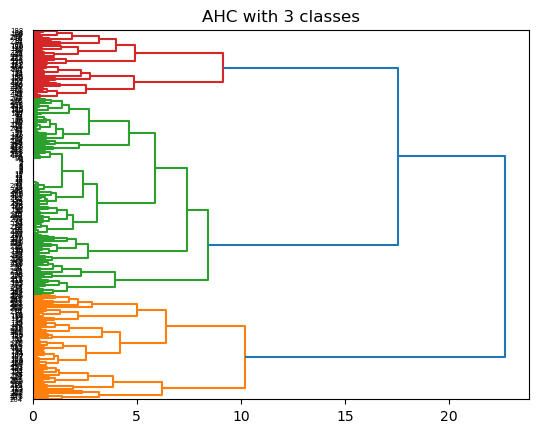

In [187]:
# delete NAN
standardized_scores = standardized_scores.dropna()

# 计算距离矩阵，使用 'ward' 方法
Z = linkage(standardized_scores, method='ward')

# show classes : cut at distance t=12
plt.title('AHC with 3 classes')
dendrogram(Z,labels = standardized_scores.index,orientation='right',color_threshold=12)
plt.show()

In [188]:
# cutting at t = 8 ==> 3 classes retained
groupes_cah = fcluster(Z,t=12,criterion='distance')
print(groupes_cah)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 3 2 3 2 2 1 2 3 2 2 1 1 2 2 2
 3 1 3 2 2 2 2 3 2 1 2 2 3 3 1 3 2 1 1 2 2 2 2 2 3 2 2 2 2 3 2 2 2 1 1 2 1
 1 1 2 3 2 2 2 3 2 1 2 2 2 3 2 2 3 3 2 1 1 3 2 2 2 1 1 1 1 2 1 2 3 1 3 1 3
 2 2 2 1 1 2 3 1 2 3 1 1 1 3 1 2 3 3 1 2 1 1 2 3 2 2 2 2 2 2 3 2 2 2 2 2 2
 2 3 1 1 2 1 1 2 2 3 2 2 1 2 1 1 2 2 3 1 3 2 2 2 1 1 2 1 1 3 2 3 2 2 3 2 2
 2 3 1 3 1 1 3 2 2 1 3 1 1 1 1 1 2 2 2 1 2 2 3 1 2 1 2 1 2 3 1 3 2 2 2 1 3
 3 1 2 2 2 3 2 3 2 1 2 3 2 1 1 1 2 2 1 1 2 2 2 1 1 2 2 2 2 1 2 2 1 2 2 2 3
 2 2 1 1 1 1 1 3 2 1 2 2 1 3 3 1 2 2 2]


In [189]:
# select indices per groups
idg = np.argsort(groupes_cah)

# plrint observations and their corresponding group
print(pd.DataFrame(standardized_scores.index[idg],groupes_cah[idg]))

      0
1    71
1   204
1   172
1   107
1   208
..  ...
3    39
3   106
3   108
3    29
3    37

[278 rows x 1 columns]


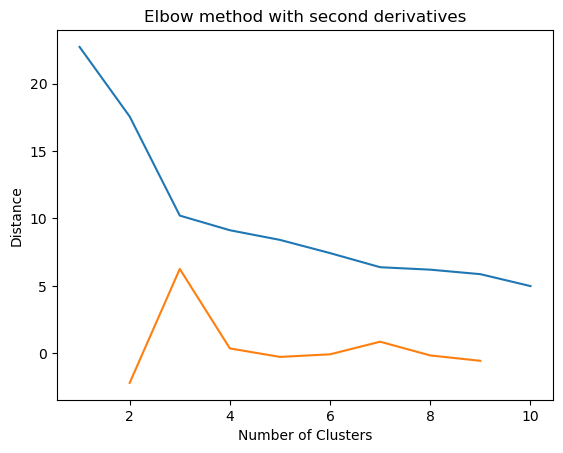

In [190]:
# Compute the linkage matrix
Z = linkage(standardized_scores,method='ward',metric='euclidean')

# Determine the optimal number of clusters using the elbow method
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.xlabel("Number of Clusters")
plt.ylabel("Distance")
plt.title("Elbow method with second derivatives")
plt.show()

In [191]:
# The elbow point represents the optimal number of clusters
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("The optimal number of clusters is:", k)

The optimal number of clusters is: 3


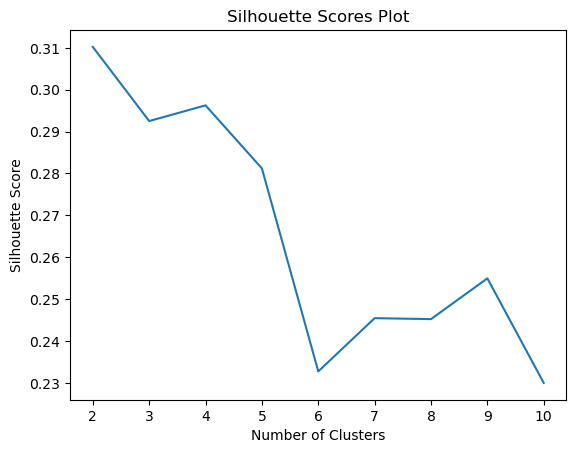

In [192]:
# Create a list to store the silhouette scores
silhouette_scores = []

# Loop over a range of possible number of clusters
for n_clusters in range(2, 11):
    # Create an instance of AgglomerativeClustering
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    
    # Fit the clusterer to the data
    clusterer.fit(standardized_scores)
    
    # Predict the cluster labels for each data point
    cluster_labels = clusterer.labels_
    
    # Compute the silhouette score for the current number of clusters
    score = silhouette_score(standardized_scores, cluster_labels)
    
    # Add the score to the list of silhouette scores
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores Plot")
plt.show()

In [193]:
# The optimal number of clusters is the value that corresponds to the highest silhouette score
best_n_clusters = np.argmax(silhouette_scores) + 2
print("The best number of clusters is:", best_n_clusters)

The best number of clusters is: 2


### k means

In [195]:
# k-means on the standardized data
from sklearn import cluster
kmeans = cluster.KMeans(n_clusters=3)
kmeans.fit(standardized_scores)

C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans(n_clusters=3)

In [196]:
# print inertia
print(kmeans.inertia_)

# aggregate indices by group
idk = np.argsort(kmeans.labels_)

393.46669749616086


In [197]:
# print instances et their groups
print(pd.DataFrame(df.index[idk],kmeans.labels_[idk]))

    Individu
0        497
0         53
0        498
0        290
0          9
..       ...
2        451
2        418
2        347
2         46
2        395

[278 rows x 1 columns]


In [198]:
# distances to the center of the observations classes
print(kmeans.transform(standardized_scores))

[[1.8009841  1.88293037 0.15360847]
 [1.8009841  1.88293037 0.15360847]
 [1.8009841  1.88293037 0.15360847]
 [1.8009841  1.88293037 0.15360847]
 [1.8009841  1.88293037 0.15360847]
 [1.8009841  1.88293037 0.15360847]
 [1.8009841  1.88293037 0.15360847]
 [1.8009841  1.88293037 0.15360847]
 [1.8009841  1.88293037 0.15360847]
 [1.8009841  1.88293037 0.15360847]
 [1.8009841  1.88293037 0.15360847]
 [1.8009841  1.88293037 0.15360847]
 [1.8009841  1.88293037 0.15360847]
 [1.8009841  1.88293037 0.15360847]
 [1.8009841  1.88293037 0.15360847]
 [1.8009841  1.88293037 0.15360847]
 [1.8009841  1.88293037 0.15360847]
 [1.8009841  1.88293037 0.15360847]
 [1.88405559 3.28953259 1.53048584]
 [1.75768075 1.97209137 0.11513282]
 [2.77676474 1.24122885 1.61912533]
 [1.70902378 2.86371133 1.06697481]
 [2.9671054  1.27996156 1.85130618]
 [1.75768075 1.97209137 0.11513282]
 [3.70897037 0.29801659 1.9859532 ]
 [1.8009841  1.88293037 0.15360847]
 [1.72116574 2.06396076 0.17316917]
 [1.49607407 2.65881616 1.52

In [199]:
# check correspondance with AHC groups
pd.crosstab(groupes_cah,kmeans.labels_)

col_0   0   1    2
row_0             
1      68   0   11
2      10   7  131
3       0  49    2

In [200]:
# package to estimate partitions
from sklearn import metrics

# sihouette score metrics
# make number of clusters vary from 0 to 10
res = np.arange(9,dtype="double")
for k in np.arange(9):
    km = cluster.KMeans(n_clusters=k+2)
    km.fit(standardized_scores)
    res[k] = metrics.silhouette_score(standardized_scores,km.labels_)
    
print(res)

C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known

[0.31528342 0.20825175 0.28994407 0.27123887 0.25138561 0.27891254
 0.24083083 0.27820774 0.273125  ]


C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


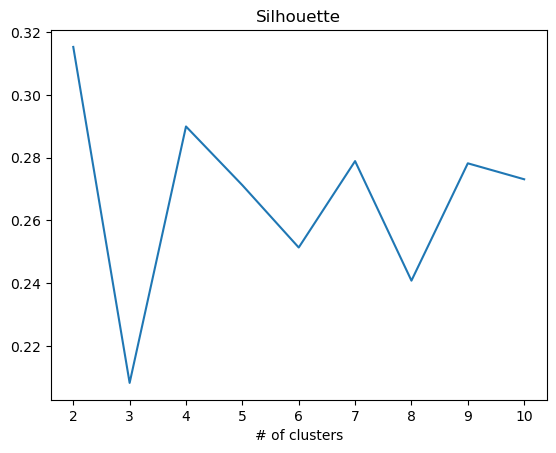

In [201]:
# plot
import matplotlib.pyplot as plt
plt.title("Silhouette")
plt.xlabel("# of clusters")
plt.plot(np.arange(2,11,1),res)
plt.show()

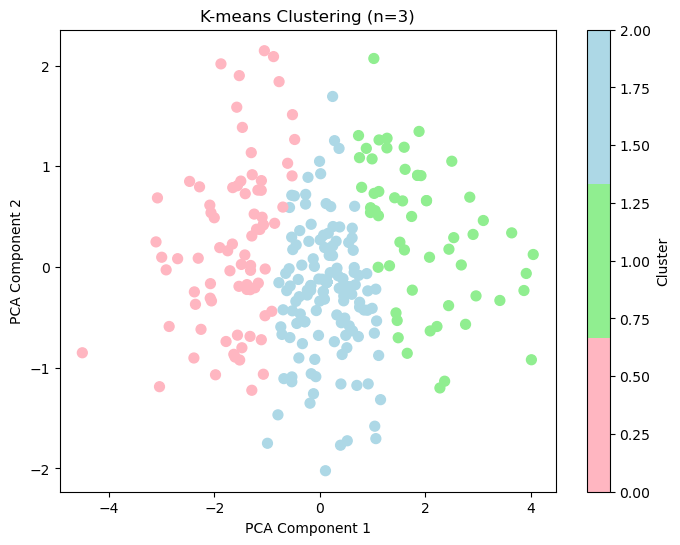

In [202]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

pca = PCA(n_components=2)
pca_data = pca.fit_transform(standardized_scores)


custom_cmap = ListedColormap(['lightpink', 'lightgreen', 'lightblue'])


plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.labels_, cmap=custom_cmap, s=50)
plt.title("K-means Clustering (n=3)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()



## interpretation 3

In [204]:
# creat cluster_label
standardized_scores['Cluster_Label'] = groupes_cah

# compute the mean of each group
group_summary = standardized_scores.groupby('Cluster_Label').mean()

group_summary

Force_Score  Flux_Score  FQ_Score
Cluster_Label                                   
1                -0.525382   -1.045192 -0.984258
2                -0.220789    0.192342  0.209097
3                 1.454550    1.060855  0.917842

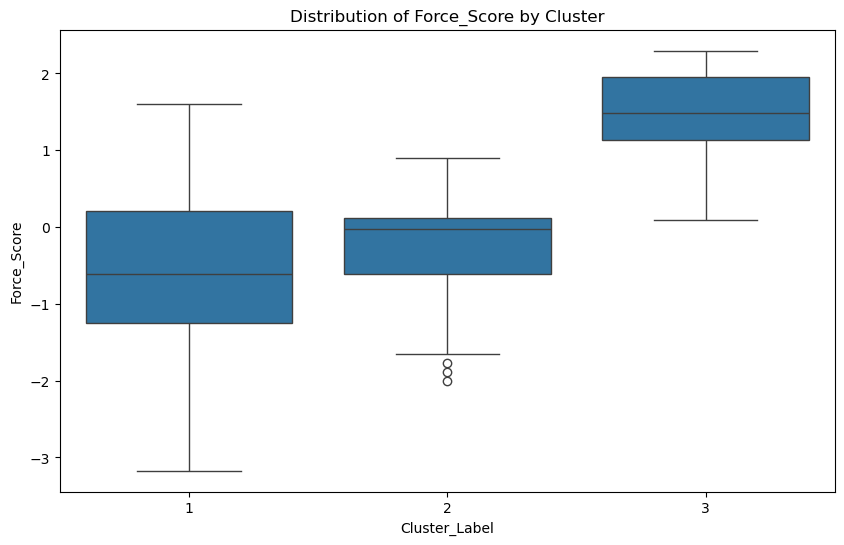

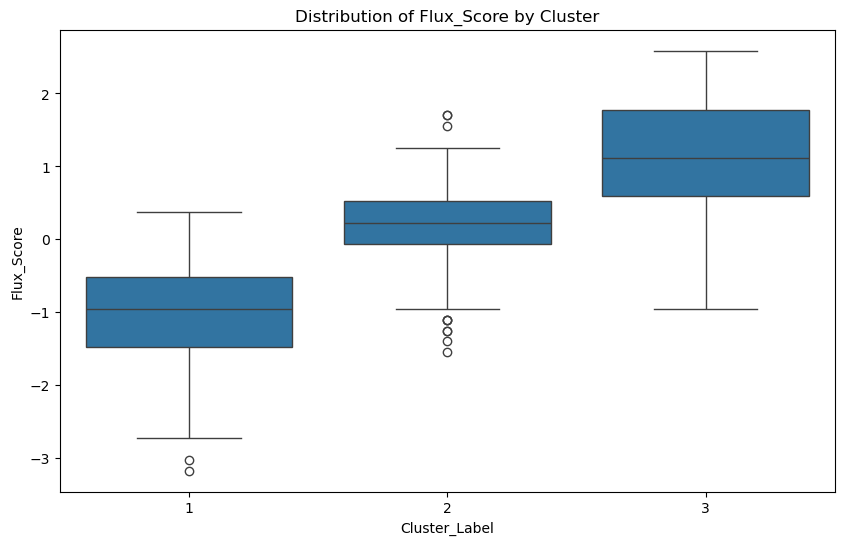

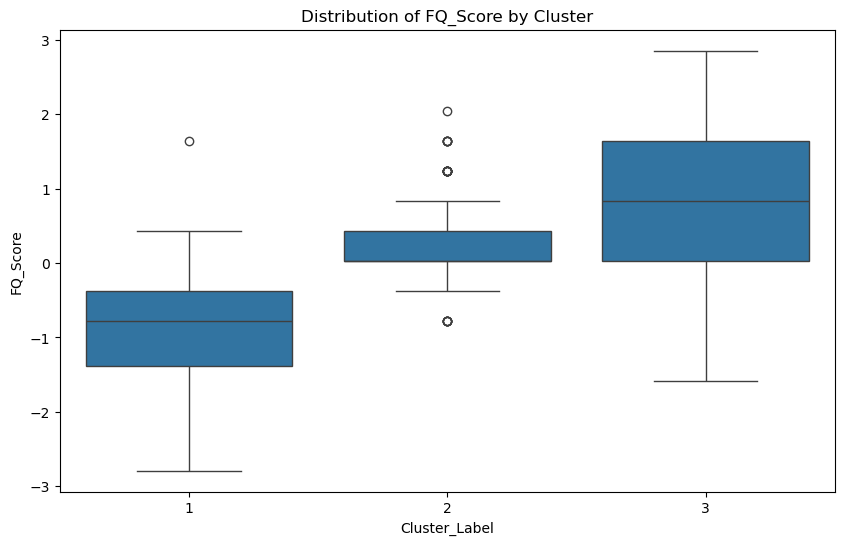

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt

# 可视化每个特征在群组中的分布
for feature in ['Force_Score', 'Flux_Score','FQ_Score']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster_Label', y=feature, data=standardized_scores)
    plt.title(f"Distribution of {feature} by Cluster")
    plt.show()

# PART 5 Multiple Linear Regression

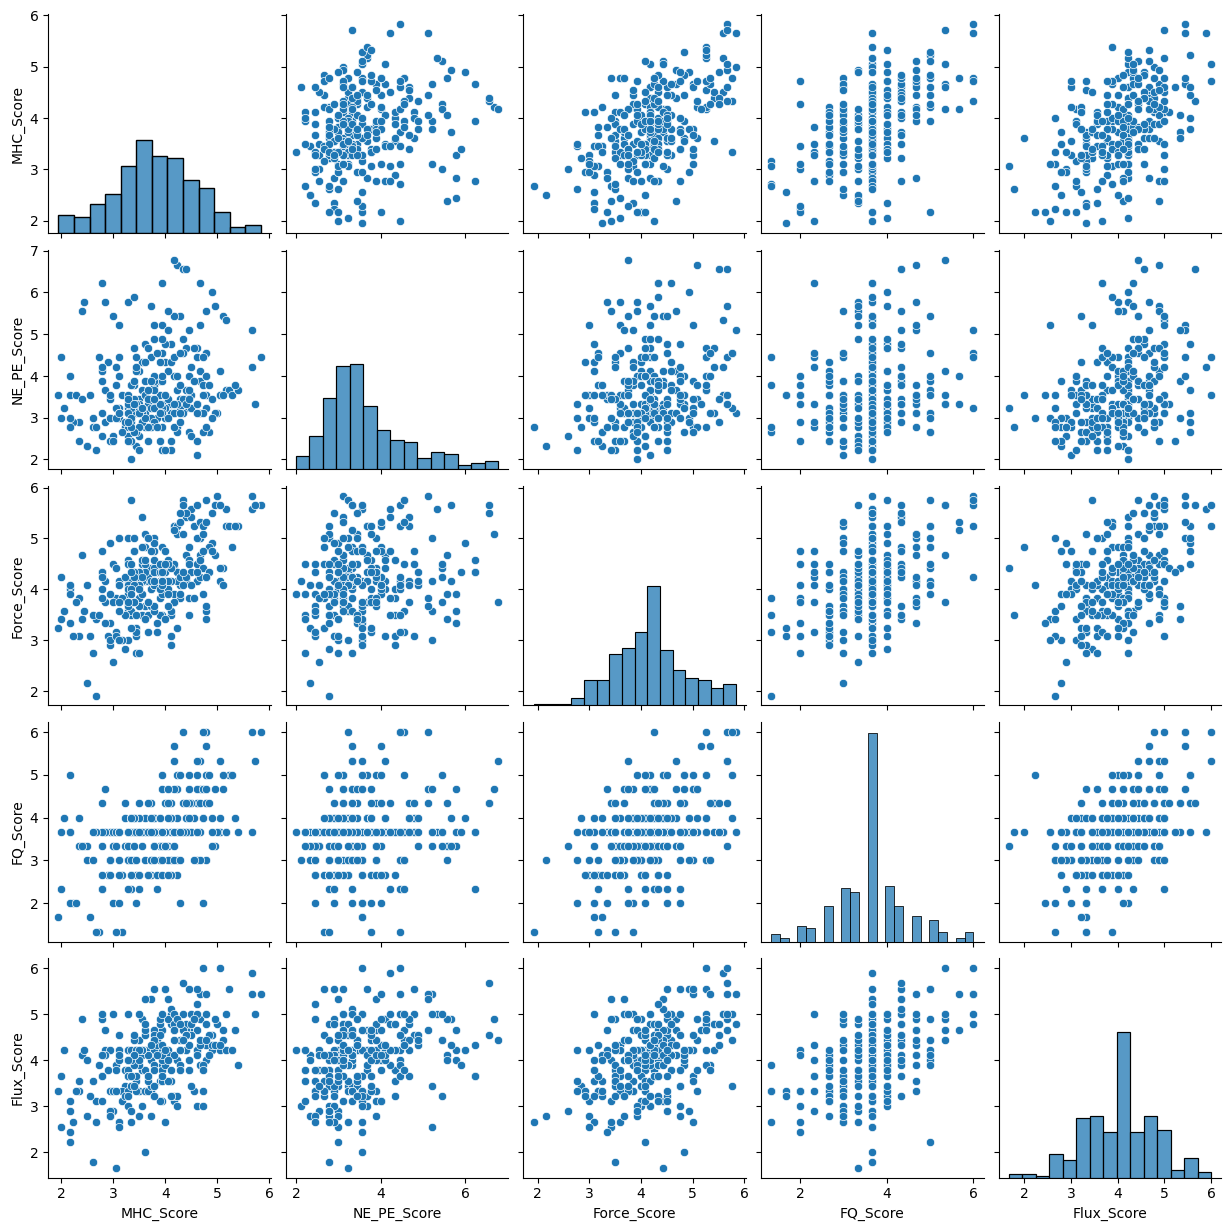

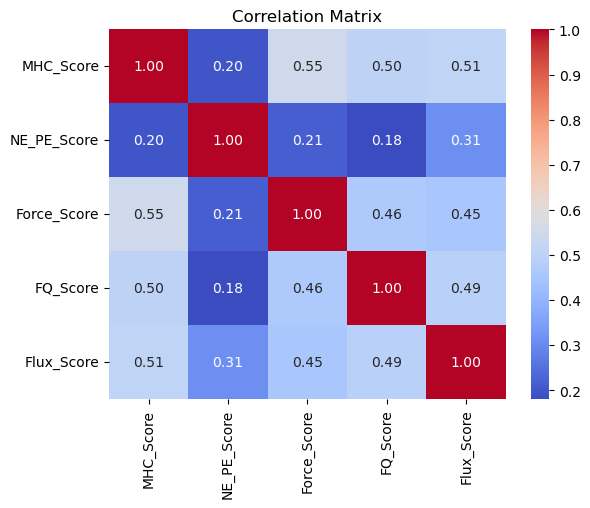

In [207]:
# Step 1: Pairplot for descriptive statistics
sns.pairplot(df_1, vars=['MHC_Score', 'NE_PE_Score', 'Force_Score', 'FQ_Score', 'Flux_Score'])
plt.show()

# Step 2: Correlation matrix to identify relationships
correlation_matrix = df_1[['MHC_Score', 'NE_PE_Score', 'Force_Score', 'FQ_Score', 'Flux_Score']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Best model

In [209]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Candidate Models
models = {
    "Model 1": ['MHC_Score'],
    "Model 2": ['MHC_Score', 'NE_PE_Score'],
    "Model 3": ['MHC_Score', 'NE_PE_Score', 'Force_Score'],
    "Model 4": ['MHC_Score', 'NE_PE_Score', 'Force_Score','FQ_Score'],
}

# Results storage
results = []

# Target variable
y = df_1['Flux_Score']

# Fit models and calculate metrics
for name, features in models.items():
    X = df_1[features]
    X = sm.add_constant(X)  # Add intercept term
    
    # Fit GLM (Gaussian with identity link for linear regression)
    model = sm.OLS(y, X).fit()
    
    # Calculate metrics
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)  # Mean Squared Error
    rmse = np.sqrt(mse)  # Root Mean Squared Error
    aic = model.aic  # Akaike Information Criterion
    bic = model.bic  # Bayesian Information Criterion
    
    # Store results
    results.append({
        "Model": name,
        "Features": features,
        "RMSE": rmse,
        "AIC": aic,
        "BIC": bic
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by AIC, BIC, and RMSE (customize as needed)
results_df = results_df.sort_values(by=['AIC', 'BIC', 'RMSE'])

# Display results
print(results_df)

     Model                                         Features      RMSE  \
3  Model 4  [MHC_Score, NE_PE_Score, Force_Score, FQ_Score]  0.591110   
2  Model 3            [MHC_Score, NE_PE_Score, Force_Score]  0.612595   
1  Model 2                         [MHC_Score, NE_PE_Score]  0.627227   
0  Model 1                                      [MHC_Score]  0.647478   

          AIC         BIC  
3  506.610667  524.748773  
2  524.461367  538.971852  
1  535.585547  546.468410  
0  551.252675  558.507918  


## Model summary

In [211]:
model_glm = glm('Flux_Score ~ MHC_Score + NE_PE_Score + Force_Score + FQ_Score', data=df_1, family=sm.families.Gaussian()).fit()

resformula= ols('Flux_Score ~ MHC_Score + NE_PE_Score + Force_Score + FQ_Score',data=df_1).fit()

# ANOVA Table for the fitted model
table = anova_lm(resformula)
print(table)

model_glm.summary()

                df     sum_sq    mean_sq           F        PR(>F)
MHC_Score      1.0  40.559377  40.559377  113.991677  1.820124e-22
NE_PE_Score    1.0   7.176102   7.176102   20.168355  1.047519e-05
Force_Score    1.0   5.043254   5.043254   14.174008  2.040804e-04
FQ_Score       1.0   7.189680   7.189680   20.206515  1.028246e-05
Residual     273.0  97.136126   0.355810         NaN           NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             Flux_Score   No. Observations:                  278
Model:                            GLM   Df Residuals:                      273
Model Family:                Gaussian   Df Model:                            4
Link Function:               Identity   Scale:                         0.35581
Method:                          IRLS   Log-Likelihood:                -248.31
Date:                Fri, 13 Dec 2024   Deviance:                       97.136
Time:                        23:10:00   Pearson chi2:                     97.1
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4547
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.0486      0.245      4.272      0.000       0.567       1.530
MHC_Score       0.2568      0.059      4.329      0.000       0.141       0.373
NE_PE_Score     0.1434      0.039      3.663      0.000       0.067       0.220
Force_Score     0.1562      0.062      2.510      0.012       0.034       0.278
FQ_Score        0.2338      0.052      4.495      0.000       0.132       0.336
===============================================================================
"""

In [212]:
# calculate standardized residuals
fitted_values = model_glm.fittedvalues
std_residuals = model_glm.resid_pearson

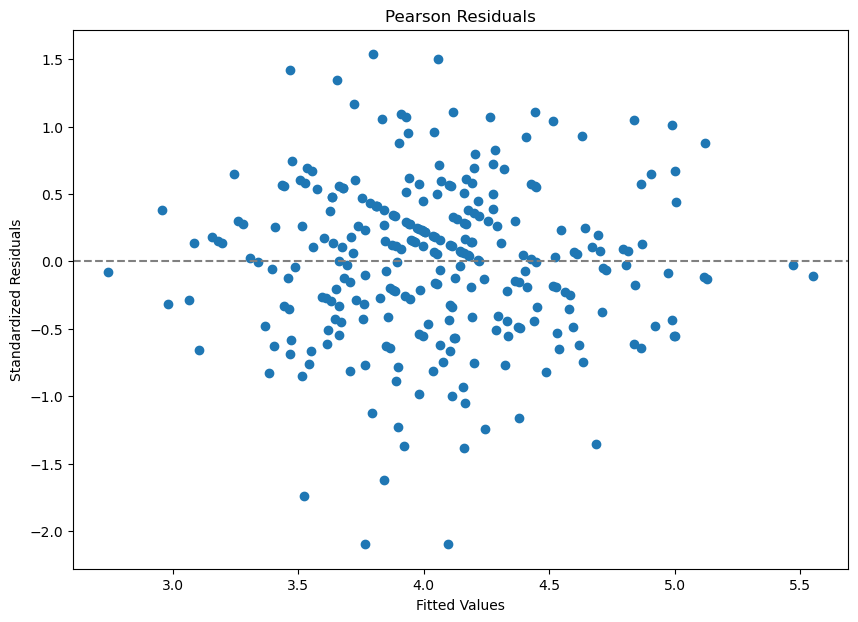

In [213]:
# plot standardized residuals
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(fitted_values, std_residuals)
ax.axhline(y=0, color='gray', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Standardized Residuals')
plt.title('Pearson Residuals')
plt.show()

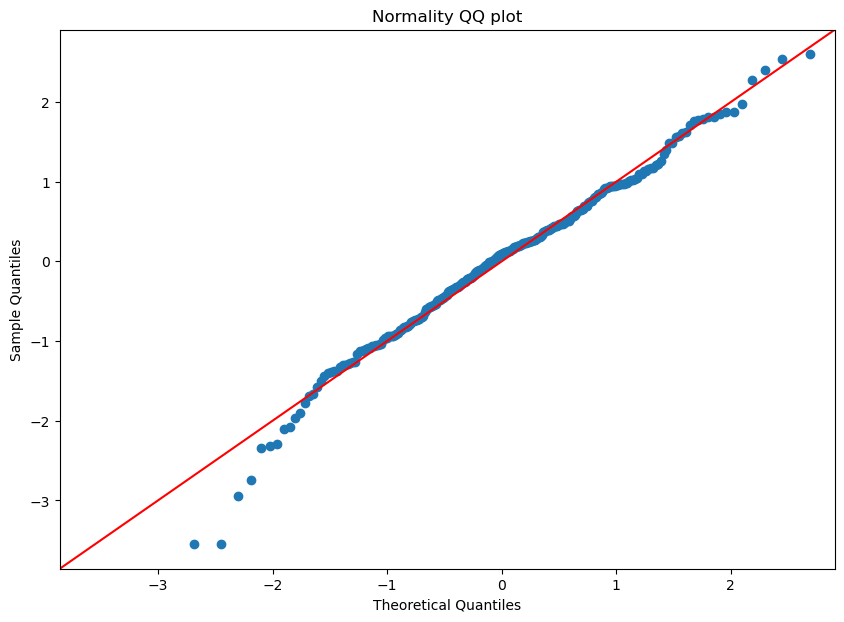

In [214]:
# check residuals normality plot
plt.rc("figure", figsize=(10,7))
sm.qqplot(model_glm.resid_pearson, fit=True, line="45")
plt.title('Normality QQ plot')
plt.show()

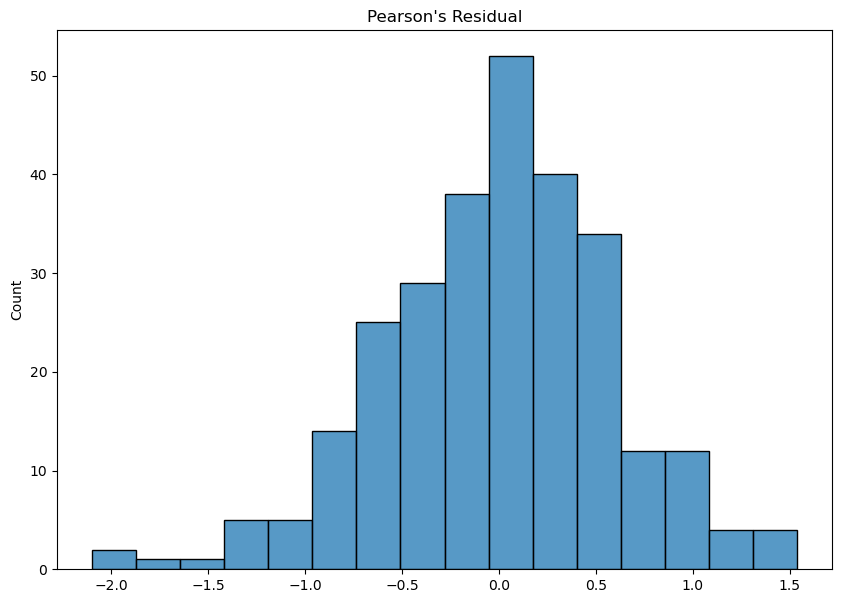

In [215]:
# check pearson's residuals distribution (histogram)
sns.histplot(model_glm.resid_pearson).set(title="Pearson's Residual");

In [216]:
diag_glm = model_glm.get_influence()

In [217]:
dir(diag_glm)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_diff_fittedvalues_one',
 '_fittedvalues_one',
 '_get_prediction',
 '_hat_matrix_diag',
 '_plot_index',
 '_res_looo',
 'cooks_distance',
 'cov_params',
 'd_fittedvalues',
 'd_fittedvalues_scaled',
 'd_linpred',
 'd_linpred_scaled',
 'd_params',
 'dfbetas',
 'endog',
 'exog',
 'hat_matrix_diag',
 'hat_matrix_exog_diag',
 'hessian',
 'k_params',
 'k_vars',
 'model_class',
 'nobs',
 'params_one',
 'plot_index',
 'plot_influence',
 'resid',
 'resid_score',
 'resid_score_factor',
 'resid_studentized',
 'results',
 'scale',
 'score_obs',
 'summary_frame']

In [218]:
diag_glm.summary_frame()

dfb_Intercept  dfb_MHC_Score  dfb_NE_PE_Score  dfb_Force_Score  \
Individu                                                                   
83             0.003232      -0.030529         0.003693         0.012664   
151            0.000997       0.007823        -0.004188        -0.002985   
177            0.000590       0.005979        -0.002104        -0.002501   
184            0.016424      -0.018593        -0.018717         0.008609   
198            0.012681      -0.008042        -0.016882         0.004241   
...                 ...            ...              ...              ...   
411           -0.075046      -0.007845        -0.006540         0.025353   
421            0.042734      -0.018864         0.037995         0.050183   
100           -0.000209       0.001860        -0.001909        -0.001311   
294            0.025801       0.149254        -0.163621        -0.016920   
395           -0.025467       0.032356         0.151709        -0.142861   

          dfb_FQ_Score   cooks_d  standard_resid  hat_diag  dffits_internal  
Individu                                                                     
83            0.009199  0.000230       -0.241279  0.019352        -0.033894  
151          -0.001874  0.000027        0.128742  0.008070         0.011612  
177          -0.001457  0.000019        0.123034  0.006145         0.009675  
184           0.009552  0.000380        0.563251  0.005955         0.043595  
198           0.005637  0.000249        0.491073  0.005138         0.035292  
...                ...       ...             ...       ...              ...  
411           0.085238  0.002997        0.743403  0.026396         0.122406  
421          -0.119375  0.004467        0.991260  0.022226         0.149452  
100           0.001607  0.000003        0.026675  0.019406         0.003753  
294          -0.043019  0.011842        1.867915  0.016687         0.243333  
395           0.094478  0.010931        1.567343  0.021765         0.233786  

[278 rows x 9 columns]

In [219]:
from statsmodels.stats.outliers_influence import OLSInfluence
diagnostics = OLSInfluence(resformula)

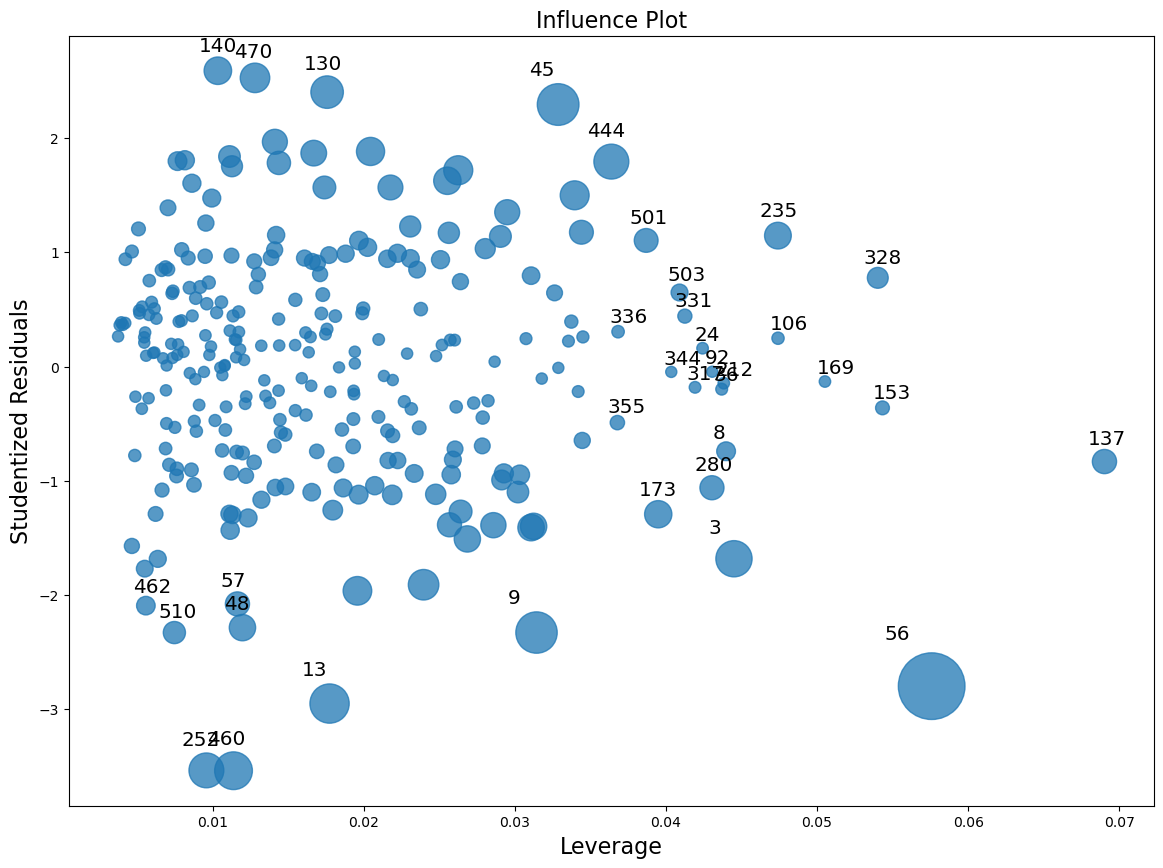

In [220]:
plt.rc("figure", figsize=(14,10))
diagnostics.plot_influence()
plt.show()

In [221]:
diagnostics.summary_frame()

dfb_Intercept  dfb_MHC_Score  dfb_NE_PE_Score  dfb_Force_Score  \
Individu                                                                   
83             0.003226      -0.030477         0.003687         0.012642   
151            0.000995       0.007809        -0.004180        -0.002980   
177            0.000589       0.005968        -0.002100        -0.002497   
184            0.016403      -0.018570        -0.018694         0.008598   
198            0.012663      -0.008031        -0.016858         0.004235   
...                 ...            ...              ...              ...   
411           -0.074984      -0.007838        -0.006534         0.025332   
421            0.042732      -0.018863         0.037994         0.050181   
100           -0.000209       0.001857        -0.001906        -0.001308   
294            0.025920       0.149942        -0.164375        -0.016998   
395           -0.025536       0.032443         0.152116        -0.143245   

          dfb_FQ_Score   cooks_d  standard_resid  hat_diag  dffits_internal  \
Individu                                                                      
83            0.009184  0.000230       -0.241279  0.019352        -0.033894   
151          -0.001871  0.000027        0.128742  0.008070         0.011612   
177          -0.001455  0.000019        0.123034  0.006145         0.009675   
184           0.009540  0.000380        0.563251  0.005955         0.043595   
198           0.005630  0.000249        0.491073  0.005138         0.035292   
...                ...       ...             ...       ...              ...   
411           0.085168  0.002997        0.743403  0.026396         0.122406   
421          -0.119371  0.004467        0.991260  0.022226         0.149452   
100           0.001604  0.000003        0.026675  0.019406         0.003753   
294          -0.043217  0.011842        1.867915  0.016687         0.243333   
395           0.094732  0.010931        1.567343  0.021765         0.233786   

          student_resid    dffits  
Individu                           
83            -0.240863 -0.033836  
151            0.128509  0.011592  
177            0.122812  0.009657  
184            0.562545  0.043540  
198            0.490390  0.035243  
...                 ...       ...  
411            0.742793  0.122305  
421            0.991228  0.149448  
100            0.026626  0.003746  
294            1.876521  0.244454  
395            1.571557  0.234414  

[278 rows x 11 columns]

## Interaction

In [223]:
# Add interaction terms manually
df_1['MHC_FQ_Interaction'] = df_1['MHC_Score'] * df_1['FQ_Score']
df_1['Force_NE_Interaction'] = df_1['Force_Score'] * df_1['NE_PE_Score']

# Fit the regression model with interaction terms
X = df_1[['MHC_Score', 'FQ_Score', 'MHC_FQ_Interaction', 'Force_Score', 'NE_PE_Score', 'Force_NE_Interaction']]
y = df_1['Flux_Score']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Flux_Score   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     28.16
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           4.31e-26
Time:                        23:10:01   Log-Likelihood:                -247.78
No. Observations:                 278   AIC:                             509.6
Df Residuals:                     271   BIC:                             535.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.5896 

# PART 6 Logistic Regression

## Binarize the SITUFAM Variable

In [226]:
# - 1 = Single (0 in binary)
# - 2/3 = Couple (1 in binary)
df['SITUFAM_binary'] = df['SITUFAM'].apply(lambda x: 0 if x == 1 else 1)

# Check the transformation
print("Binarized SITUFAM variable:")
print(df[['SITUFAM', 'SITUFAM_binary']].head())

# Count occurrences of each category to confirm the transformation
print("\nCounts of binary SITUFAM:")
print(df['SITUFAM_binary'].value_counts())

Binarized SITUFAM variable:
          SITUFAM  SITUFAM_binary
Individu                         
83            3.0               1
151           3.0               1
177           3.0               1
184           3.0               1
198           3.0               1

Counts of binary SITUFAM:
SITUFAM_binary
1    237
0     41
Name: count, dtype: int64


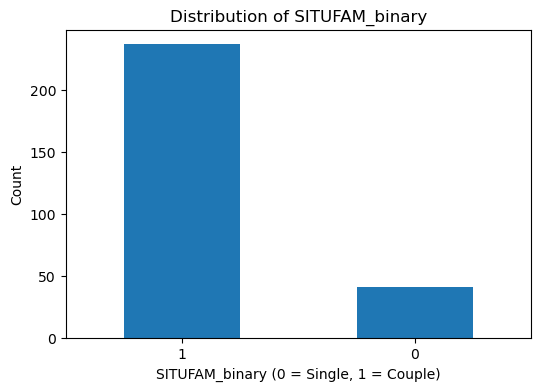

In [227]:
# the distribution of the binary target variable.
plt.figure(figsize=(6, 4))
df['SITUFAM_binary'].value_counts().plot(kind='bar')
plt.title('Distribution of SITUFAM_binary')
plt.xlabel('SITUFAM_binary (0 = Single, 1 = Couple)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## Predict Binary SITUFAM Using All Aggregated Variables

In [229]:
# Prepare predictors (all numeric variables) and target
X = df.select_dtypes(include=['float64', 'int64']).drop(columns=['SITUFAM', 'SITUFAM_binary'])
y = df['SITUFAM_binary']

# Add a constant for the intercept
X = sm.add_constant(X)

# Fit a logistic regression model using statsmodels GLM
glm_binom = sm.GLM(y, X, family=sm.families.Binomial())
result = glm_binom.fit()

# Display the model summary
print("Full Logistic Regression Model Summary:")
print(result.summary())

Full Logistic Regression Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:         SITUFAM_binary   No. Observations:                  278
Model:                            GLM   Df Residuals:                      221
Model Family:                Binomial   Df Model:                           56
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -79.086
Date:                Fri, 13 Dec 2024   Deviance:                       158.17
Time:                        23:10:02   Pearson chi2:                     262.
No. Iterations:                    11   Pseudo R-squ. (CS):             0.2348
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const     

In [230]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# Use significant predictors from the full model (manually selected)
significant_vars = ['AGE', 'MHCC3', 'MHCC10']  # Example significant variables
X_reduced = sm.add_constant(df[significant_vars])

# Fit a reduced GLM logistic regression model
glm_reduced = sm.GLM(y, X_reduced, family=sm.families.Binomial())
result_reduced = glm_reduced.fit()

# Predict probabilities and convert to binary predictions
y_pred_proba = result_reduced.predict(X_reduced)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate performance
accuracy = accuracy_score(y, y_pred)
conf_matrix = confusion_matrix(y, y_pred)
roc_auc = roc_auc_score(y, y_pred_proba)

# Print evaluation metrics
print(f"Model Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"ROC AUC Score: {roc_auc:.2f}")

Model Accuracy: 0.86
Confusion Matrix:
[[  4  37]
 [  3 234]]
ROC AUC Score: 0.74


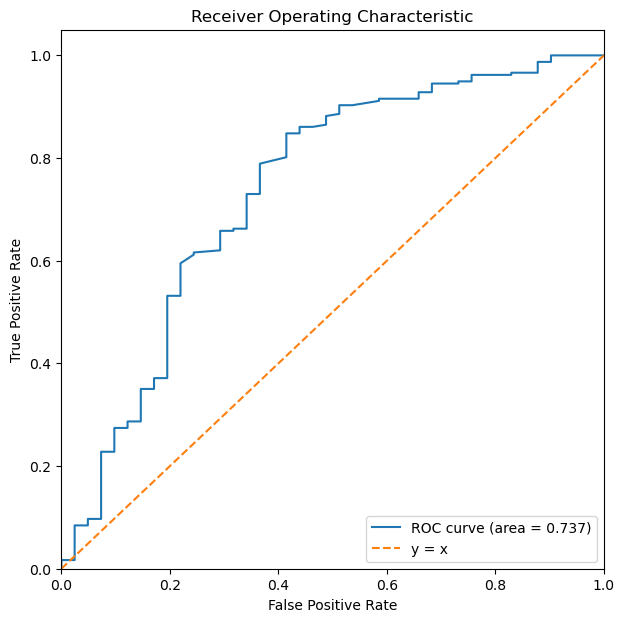

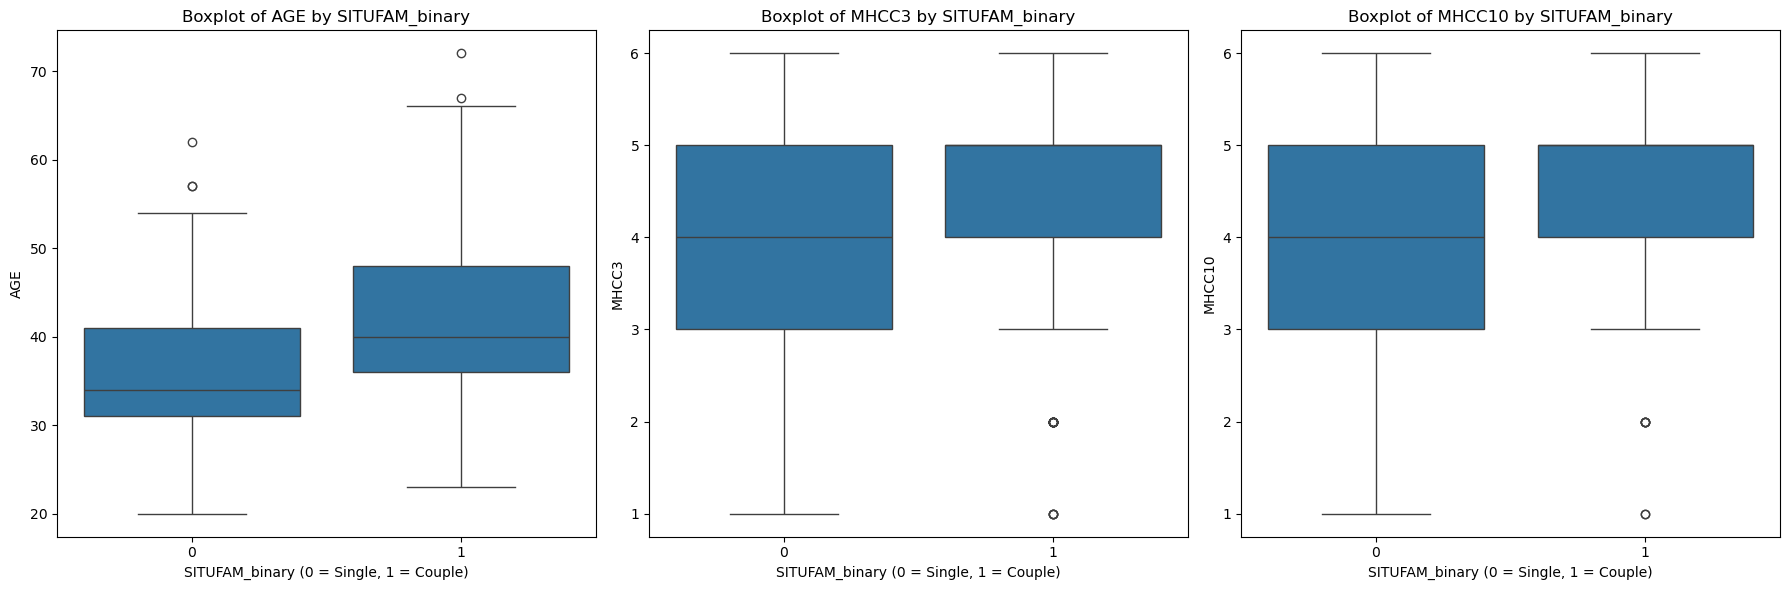

In [231]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_curve, auc

# 1. ROC Curve for the Reduced Mode

# Generate ROC curve values
fpr, tpr, _ = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='y = x')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 2. Boxplots for Significant Predictors
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# AGE
sns.boxplot(x='SITUFAM_binary', y='AGE', data=df, ax=axes[0])
axes[0].set_title('Boxplot of AGE by SITUFAM_binary')
axes[0].set_xlabel('SITUFAM_binary (0 = Single, 1 = Couple)')
axes[0].set_ylabel('AGE')

# MHCC3
sns.boxplot(x='SITUFAM_binary', y='MHCC3', data=df, ax=axes[1])
axes[1].set_title('Boxplot of MHCC3 by SITUFAM_binary')
axes[1].set_xlabel('SITUFAM_binary (0 = Single, 1 = Couple)')
axes[1].set_ylabel('MHCC3')

# MHCC10
sns.boxplot(x='SITUFAM_binary', y='MHCC10', data=df, ax=axes[2])
axes[2].set_title('Boxplot of MHCC10 by SITUFAM_binary')
axes[2].set_xlabel('SITUFAM_binary (0 = Single, 1 = Couple)')
axes[2].set_ylabel('MHCC10')

plt.tight_layout()
plt.show()